# Building a Retrieval-Augmented Generation (RAG) System from Scratch

**Author:** Manish Kumar  
**Course:** INFO 7390 - Advanced Data Science and Architecture  
**Institution:** Northeastern University   
**Date:** December 2025  

---

## Abstract

Retrieval-Augmented Generation (RAG) represents a paradigm shift in how we build intelligent question-answering systems. By combining the power of information retrieval with large language models, RAG systems can provide accurate, contextual, and up-to-date responses without requiring expensive model retraining. This notebook provides a comprehensive, hands-on guide to building a RAG system from scratch.

**What You'll Learn:**
- The theoretical foundations of RAG architecture
- How to create and work with vector embeddings
- Building efficient retrieval mechanisms using vector similarity
- Implementing context-aware generation pipelines
- Evaluating RAG system performance
- Best practices and common pitfalls

**Technical Approach:**  
This implementation uses locally-runnable models (sentence-transformers for embeddings, FLAN-T5 for generation) to ensure complete reproducibility without API dependencies. All code is production-ready and includes comprehensive error handling, logging, and evaluation metrics.

**Target Audience:**  
Data scientists, ML engineers, and developers with intermediate Python knowledge who want to understand and implement RAG systems for real-world applications.

---

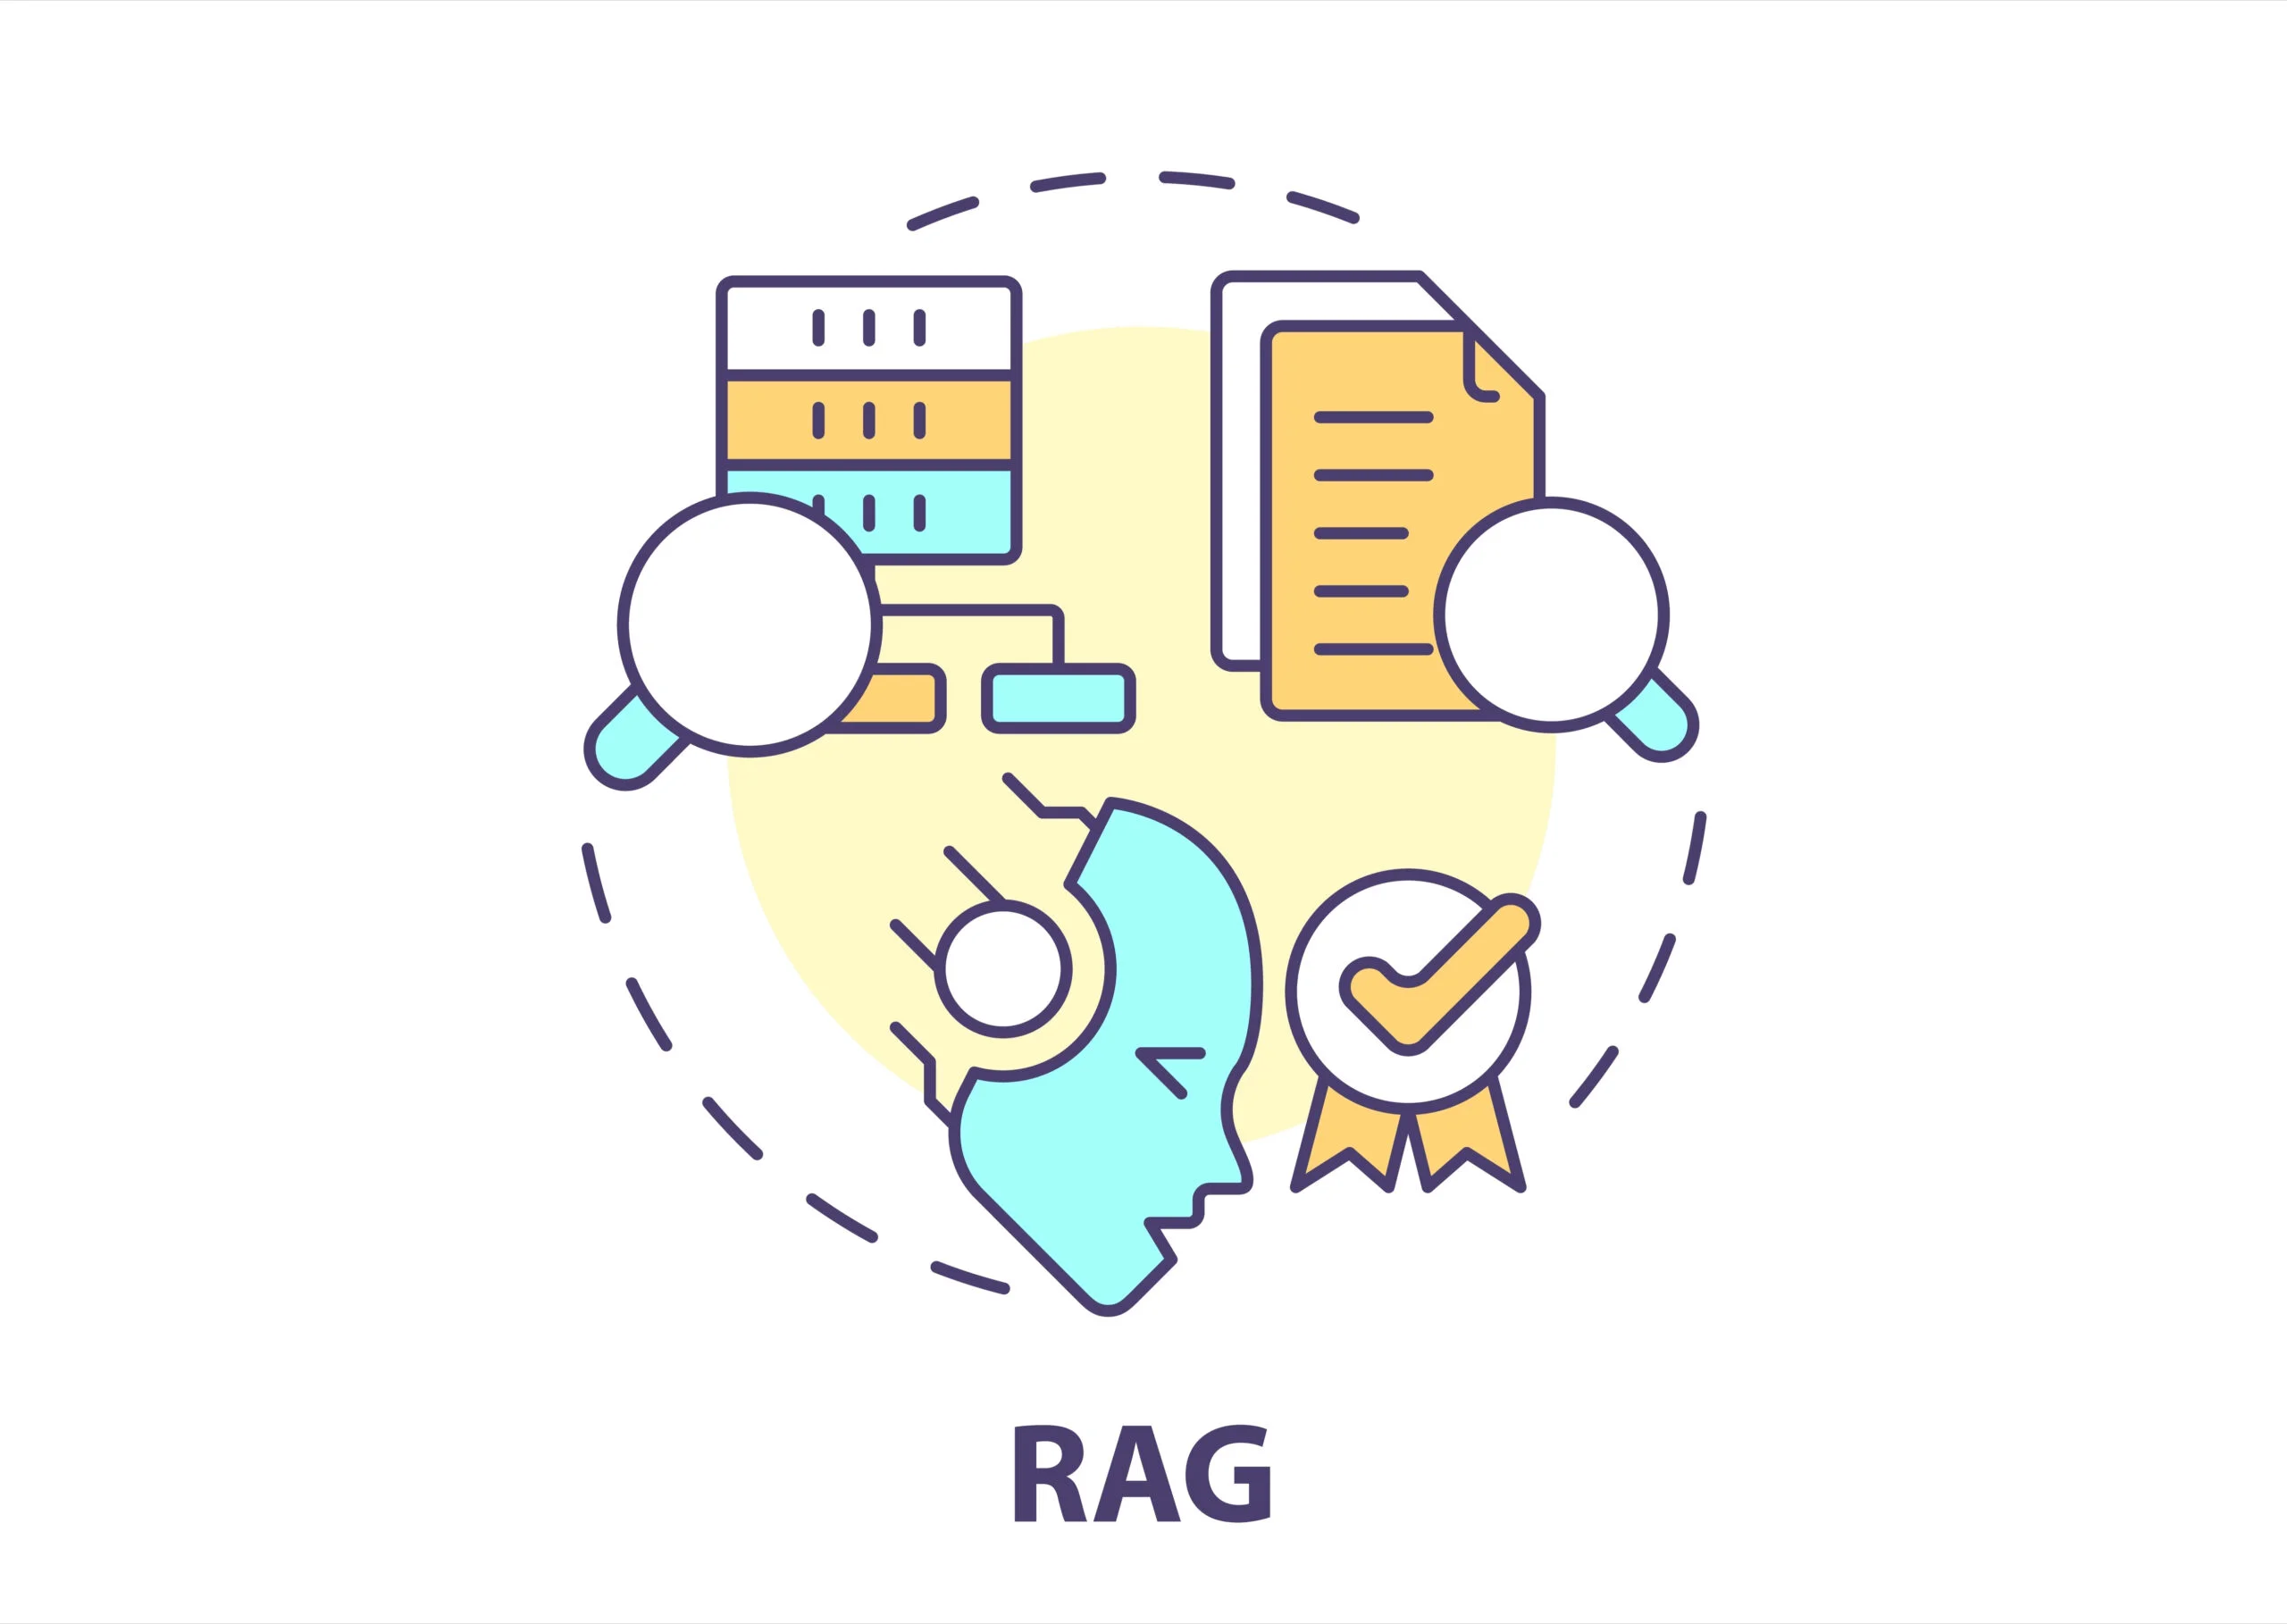

## Table of Contents

1. [Introduction](#1-introduction)
2. [Theory: Understanding RAG](#2-theory-understanding-rag)
   - 2.1 [What is RAG?](#21-what-is-rag)
   - 2.2 [Why RAG? The Problem It Solves](#22-why-rag-the-problem-it-solves)
   - 2.3 [RAG Architecture](#23-rag-architecture)
   - 2.4 [Components Deep Dive](#24-components-deep-dive)
   - 2.5 [RAG vs. Fine-tuning vs. Prompt Engineering](#25-rag-vs-fine-tuning-vs-prompt-engineering)
   - 2.6 [Real-World Use Cases](#26-real-world-use-cases)
3. [Setup and Dependencies](#3-setup-and-dependencies)
4. [Practical Implementation](#4-practical-implementation)
   - 4.1 [Document Preparation and Chunking](#41-document-preparation-and-chunking)
   - 4.2 [Creating Embeddings](#42-creating-embeddings)
   - 4.3 [Building the Vector Store](#43-building-the-vector-store)
   - 4.4 [Implementing Retrieval](#44-implementing-retrieval)
   - 4.5 [Context-Aware Generation](#45-context-aware-generation)
   - 4.6 [Complete RAG Pipeline](#46-complete-rag-pipeline)
5. [Evaluation and Metrics](#5-evaluation-and-metrics)
6. [Visualizations and Analysis](#6-visualizations-and-analysis)
7. [Advanced Topics and Extensions](#7-advanced-topics-and-extensions)
8. [Conclusion](#8-conclusion)
9. [References](#9-references)
10. [License](#10-license)

---

## 1. Introduction

Imagine you're building a customer support chatbot for a technology company. The chatbot needs to answer questions about thousands of products, policies, and procedures. Traditional approaches face significant challenges:

- **Fine-tuning** a language model on all this information is expensive and requires retraining whenever information changes
- **Prompt engineering** alone hits token limits and struggles with large knowledge bases
- **Pre-trained models** don't know about your company-specific information

**Enter RAG (Retrieval-Augmented Generation)**

RAG solves this by combining the best of both worlds:
1. **Retrieval**: Quickly find relevant information from a knowledge base
2. **Generation**: Use an LLM to synthesize natural, contextual responses

This notebook will teach you to build a complete RAG system from the ground up, understanding every component and design decision along the way.

---

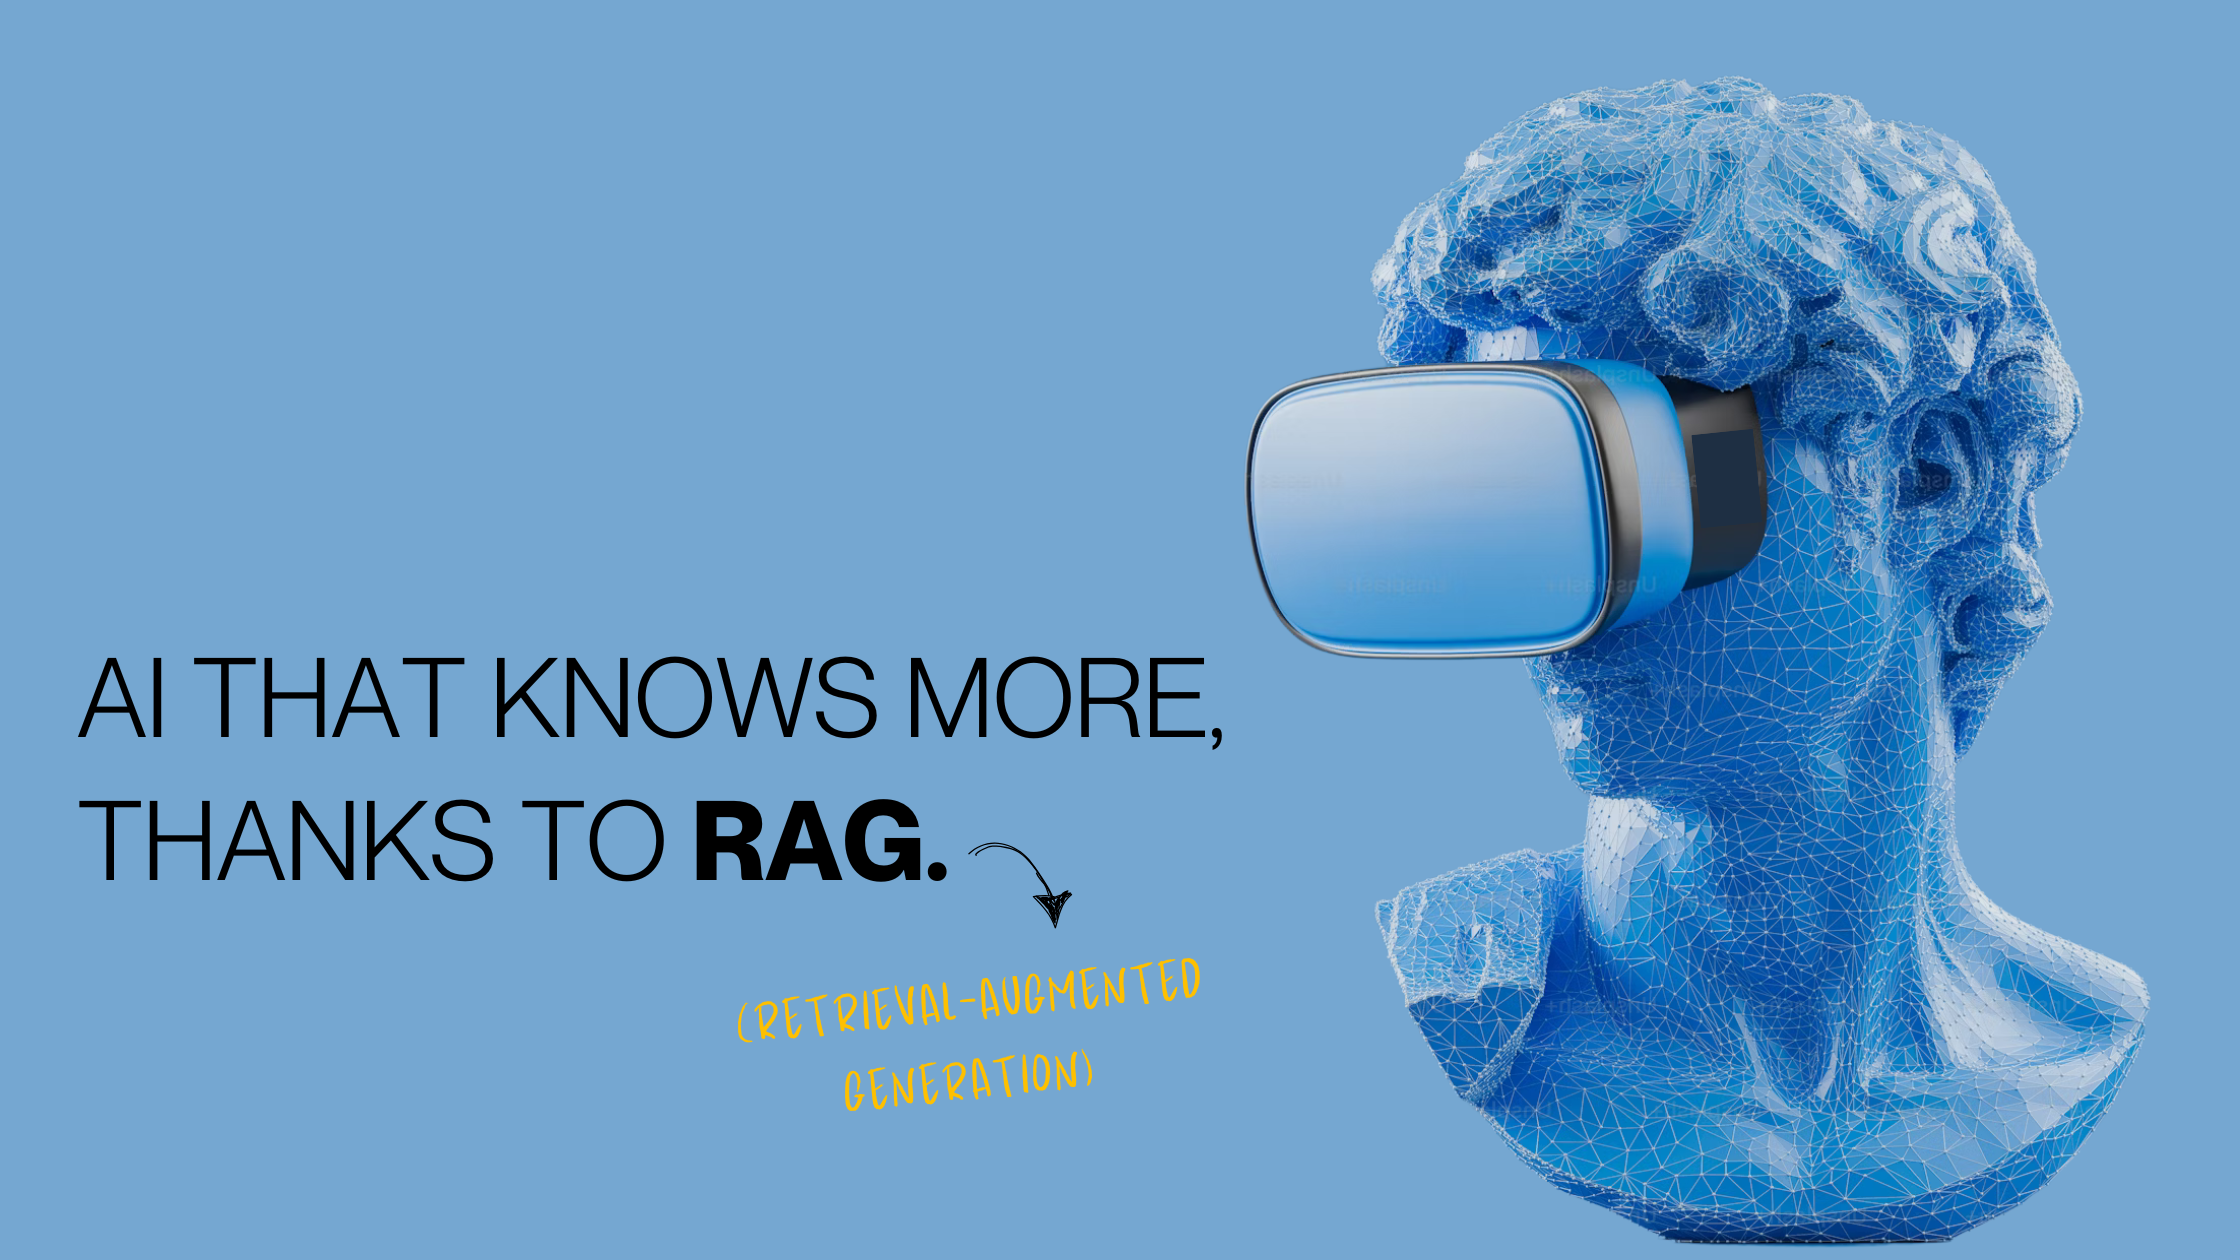

## 2. Theory: Understanding RAG

Before diving into code, let's build a solid theoretical foundation. Understanding *why* RAG works is crucial for building effective systems.

### 2.1 What is RAG?

**Retrieval-Augmented Generation (RAG)** is a technique that enhances large language model responses by retrieving relevant information from an external knowledge base before generating an answer.

**The Three-Step Process:**

```
┌─────────────┐      ┌─────────────┐      ┌─────────────┐
│   User      │      │  Retrieval  │      │  Generation │
│   Query     │─────>│   System    │─────>│    (LLM)    │─────> Response
└─────────────┘      └─────────────┘      └─────────────┘
                            │
                            ├── Vector Database
                            └── Knowledge Base
```

**Key Insight:** Instead of relying solely on an LLM's parametric memory (what it learned during training), RAG augments it with non-parametric memory (external documents), providing:
- **Accuracy**: Grounded in actual source documents
- **Recency**: Can incorporate latest information
- **Transparency**: Can cite sources
- **Cost-effectiveness**: No need for expensive retraining




---

### 2.2 Why RAG? The Problem It Solves

#### Problem 1: Knowledge Cutoff
LLMs are trained on data up to a certain date. They can't know about:
- Recent events
- Company-specific information
- Private or proprietary knowledge

**RAG Solution:** Retrieves current, relevant documents at query time.

#### Problem 2: Hallucination
LLMs sometimes generate plausible-sounding but incorrect information.

**RAG Solution:** Grounds responses in actual source documents, reducing fabrication.

#### Problem 3: Context Window Limitations
Even large context windows (100K+ tokens) can't hold entire knowledge bases.

**RAG Solution:** Only retrieves and includes the most relevant pieces of information.

#### Problem 4: Cost and Maintenance
Fine-tuning models for every knowledge update is expensive and slow.

**RAG Solution:** Simply update the knowledge base; no model retraining needed.

---


### 2.3 RAG Architecture



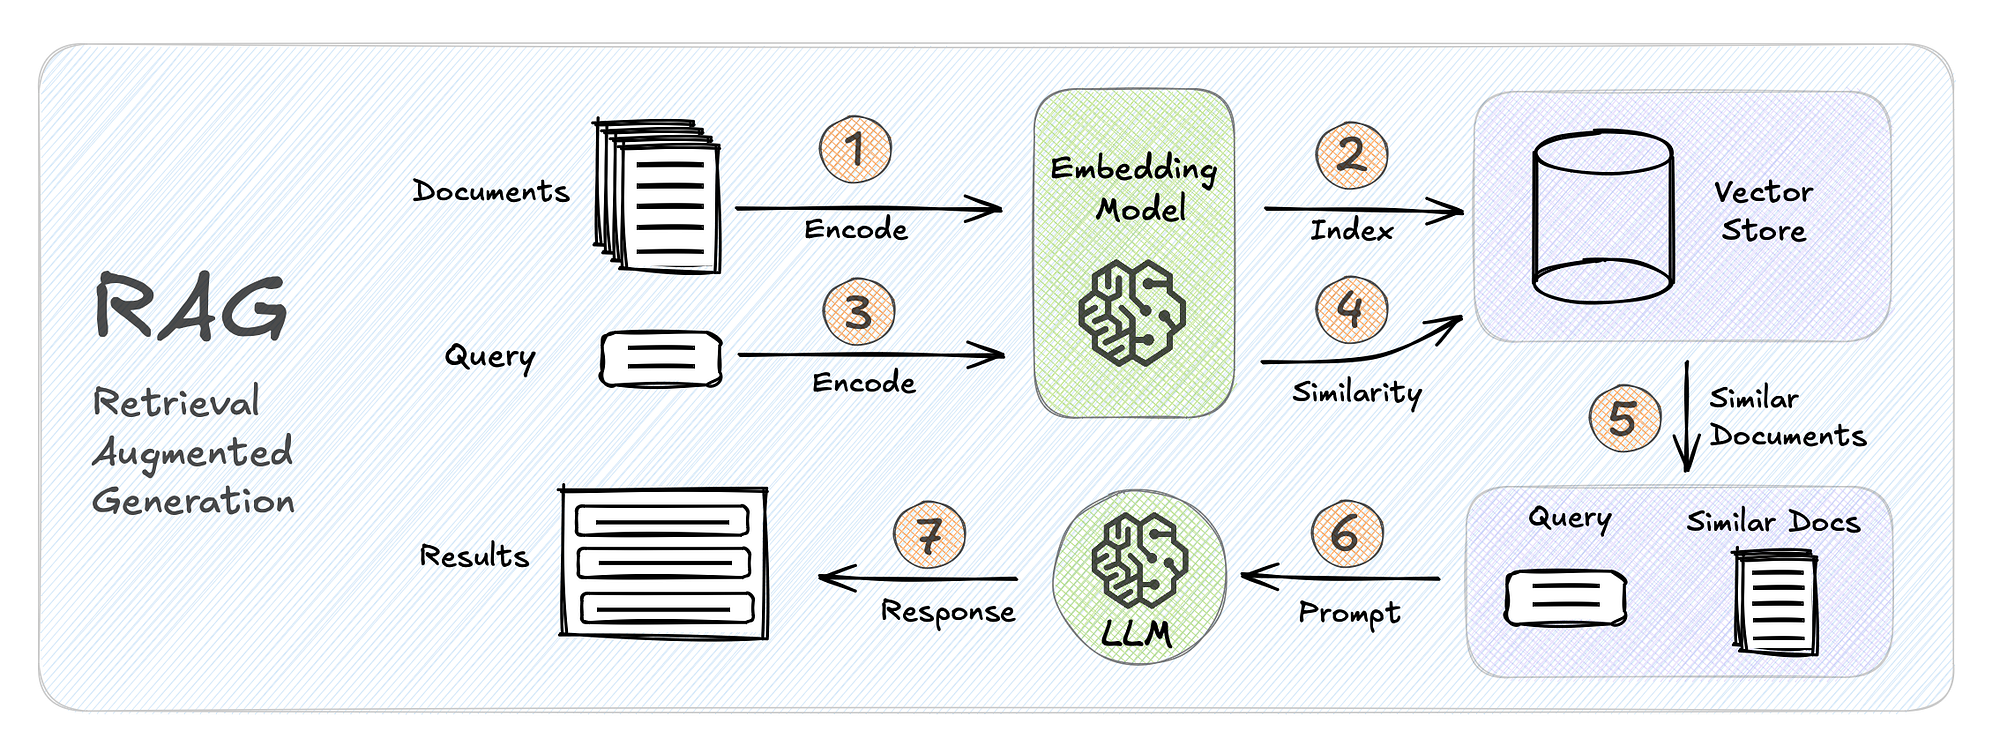
A production RAG system consists of two main phases:

#### Phase 1: Indexing (Offline)
```
Documents → Chunking → Embedding → Vector Store
```

1. **Document Collection**: Gather source documents (PDFs, web pages, databases)
2. **Text Splitting**: Break documents into manageable chunks (typically 200-1000 tokens)
3. **Embedding Generation**: Convert chunks into dense vector representations
4. **Indexing**: Store vectors in a database optimized for similarity search

#### Phase 2: Retrieval and Generation (Online)
```
Query → Embedding → Similarity Search → Context Injection → LLM → Response
```

1. **Query Processing**: Convert user question into same vector space
2. **Retrieval**: Find top-k most similar document chunks
3. **Context Assembly**: Combine retrieved chunks into prompt context
4. **Generation**: LLM generates response using retrieved context
5. **Post-processing**: Format and validate response

---

### 2.4 Components Deep Dive

#### 2.4.1 Text Chunking

**Why Chunk?**
- Embedding models have token limits
- Smaller chunks → more precise retrieval
- Balance between context and granularity

**Chunking Strategies:**
1. **Fixed-size**: Split every N tokens (simple but may break context)
2. **Sentence-based**: Split on sentence boundaries (preserves meaning)
3. **Semantic**: Split based on topic changes (advanced)
4. **Recursive**: Split by paragraphs, then sentences, then tokens

**Best Practices:**
- Use overlap between chunks (50-200 tokens) to preserve context
- Chunk size: 300-500 tokens for most applications
- Maintain metadata (source document, page number, timestamps)

#### 2.4.2 Embeddings

**What are Embeddings?**
Numerical vector representations of text that capture semantic meaning. Similar concepts have similar vectors.

**Mathematical Intuition:**
```
Text → Encoder → Dense Vector (e.g., 768 dimensions)

"machine learning" → [0.12, -0.43, 0.78, ..., 0.23]
"artificial intelligence" → [0.15, -0.41, 0.74, ..., 0.21]
"cooking recipe" → [-0.52, 0.31, -0.19, ..., -0.44]
```

**Popular Embedding Models:**
- **sentence-transformers**: Open-source, runs locally, good quality
- **OpenAI ada-002**: High quality, requires API
- **Cohere**: Optimized for RAG use cases

**Key Properties:**
- Dimensionality: 384-1536 (higher = more expressive but slower)
- Cosine similarity measures semantic closeness
- Same model must be used for documents and queries

#### 2.4.3 Vector Stores

**Purpose:** Efficiently store and search millions of vectors.

**Similarity Search Algorithms:**
1. **Exact Search** (FAISS Flat): 100% accurate, slow for large datasets
2. **Approximate Search** (HNSW, IVF): Fast, 90-99% recall

**Popular Vector Databases:**
- **FAISS**: Facebook's library, fast and flexible
- **Pinecone**: Managed service, easy to use
- **Weaviate**: Open-source, production-ready
- **Chroma**: Developer-friendly, good for prototyping

#### 2.4.4 Retrieval Strategies

**Basic: Top-K Similarity**
```python
# Retrieve k most similar chunks
results = vector_store.search(query_vector, k=5)
```

**Advanced: Hybrid Search**
- Combine vector similarity with keyword search (BM25)
- Better for specific terms and names

**Re-ranking**
- Use a separate model to re-score retrieved documents
- Improves precision at the cost of latency

#### 2.4.5 Context Injection

**Prompt Engineering for RAG:**
```
System: You are a helpful assistant. Use the context below to answer.

Context:
[Retrieved Document 1]
[Retrieved Document 2]
[Retrieved Document 3]

Question: {user_query}

Instructions:
- Answer based on the context provided
- If unsure, say "I don't have enough information"
- Cite source documents when possible
```

**Critical Considerations:**
- Context placement (beginning vs. end of prompt)
- Handling contradictory information
- Token budget management

---

### 2.5 RAG vs. Fine-tuning vs. Prompt Engineering

| Aspect | RAG | Fine-tuning | Prompt Engineering |
|--------|-----|-------------|--------------------|
| **Setup Cost** | Medium | High | Low |
| **Update Frequency** | Easy (update docs) | Hard (retrain) | Immediate |
| **Knowledge Scope** | Unlimited (external DB) | Limited (model weights) | Limited (context window) |
| **Accuracy** | High (grounded) | Very High | Variable |
| **Transparency** | High (can cite sources) | Low | Medium |
| **Latency** | Medium | Low | Low |
| **Best For** | Dynamic knowledge, citations | Specific tasks, style | Quick iterations |

**When to Use What:**
- **RAG**: Question answering over documents, customer support, research assistants
- **Fine-tuning**: Specific writing styles, domain-specific language, task optimization
- **Prompt Engineering**: Quick prototypes, simple tasks, no infrastructure
- **Combination**: Use fine-tuned models with RAG for best results!

---

### 2.6 Real-World Use Cases

#### 1. Enterprise Knowledge Management
**Problem:** Employees spend hours searching for company information.  
**RAG Solution:** Chatbot that can answer questions about policies, procedures, and past projects.

#### 2. Customer Support
**Problem:** Support agents need quick access to product documentation.  
**RAG Solution:** AI assistant that retrieves relevant help articles and generates contextual responses.

#### 3. Legal Document Analysis
**Problem:** Lawyers need to find relevant precedents across thousands of cases.  
**RAG Solution:** Semantic search over case law with AI-generated summaries.

#### 4. Medical Information Retrieval
**Problem:** Doctors need current research on rare conditions.  
**RAG Solution:** Search medical literature with evidence-based responses.

#### 5. E-commerce Product Recommendations
**Problem:** Customers ask complex questions about products.  
**RAG Solution:** Natural language search with comparison and recommendation generation.

---

## 3. Setup and Dependencies

Let's install and import all necessary libraries. This implementation uses only open-source, locally-runnable models.

In [1]:
# Install required packages (run once)
# Uncomment the following lines if running for the first time:

# First, explicitly upgrade huggingface_hub to a version that includes the required functions
# The function 'split_torch_state_dict_into_shards' was added in v0.21.0
# We upgrade to a more recent stable version (e.g., >=0.25.0) to resolve broader dependency warnings.
!pip install --upgrade huggingface_hub>=0.25.0

# Then install/upgrade other packages, which will now use the compatible huggingface_hub version
!pip install --upgrade transformers
!pip install --upgrade sentence-transformers

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

print("✓ Installation complete!")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.57.3 requires huggingface-hub<1.0,>=0.34.0, but you have huggingface-hub 1.2.2 which is incompatible.
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
Using cached huggingface_hub-0.36.0-py3-none-any.whl (566 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 1.2.2
    Uninstalling huggingface_hub-1.2.2:
      Successfully uninstalled huggingface_hub-1.2.2
✓ Installation complete!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# Import core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional
import warnings
import logging
from tqdm.auto import tqdm
import time
import json
import re

# NLP and ML libraries
import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import faiss
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import nltk

# Configuration
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set style for visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Download NLTK data (run once)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)

print("✓ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

✓ All libraries imported successfully!
PyTorch version: 2.9.0+cu126
CUDA available: False


## 4. Practical Implementation

Now we'll build each component of our RAG system step by step.

### 4.1 Document Preparation and Chunking

The first step is preparing our knowledge base. We'll create a sample document corpus and implement intelligent chunking.

In [3]:
# Sample Knowledge Base: Information about Machine Learning
# In practice, this would come from PDFs, databases, or web scraping

KNOWLEDGE_BASE = [
    {
        "title": "Introduction to Machine Learning",
        "content": """Machine Learning is a subset of artificial intelligence that enables computers to learn
        from data without being explicitly programmed. The core idea is to use algorithms that can identify
        patterns in data and make predictions or decisions based on those patterns. There are three main types
        of machine learning: supervised learning, unsupervised learning, and reinforcement learning.
        Supervised learning uses labeled data to train models that can predict outputs for new inputs.
        Common applications include image classification, spam detection, and price prediction.""",
        "category": "ML Basics",
        "source": "ML_Textbook_Chapter1.pdf"
    },
    {
        "title": "Deep Learning Neural Networks",
        "content": """Deep Learning is a specialized branch of machine learning that uses artificial neural networks
        with multiple layers. These networks are inspired by the structure and function of the human brain.
        Each layer in a neural network processes information and passes it to the next layer, allowing the
        network to learn increasingly complex features. Deep learning has achieved remarkable success in
        computer vision, natural language processing, and speech recognition. Popular architectures include
        Convolutional Neural Networks (CNNs) for image tasks and Recurrent Neural Networks (RNNs) for
        sequential data. Training deep networks requires large amounts of data and computational power.""",
        "category": "Deep Learning",
        "source": "Deep_Learning_Guide.pdf"
    },
    {
        "title": "Natural Language Processing",
        "content": """Natural Language Processing (NLP) is a field at the intersection of computer science,
        artificial intelligence, and linguistics. NLP focuses on enabling computers to understand, interpret,
        and generate human language. Key NLP tasks include text classification, named entity recognition,
        sentiment analysis, machine translation, and question answering. Modern NLP relies heavily on
        transformer architectures like BERT, GPT, and T5. These models use attention mechanisms to capture
        context and relationships between words in text. Pre-training on large text corpora allows these
        models to learn general language understanding before fine-tuning on specific tasks.""",
        "category": "NLP",
        "source": "NLP_Fundamentals.pdf"
    },
    {
        "title": "Machine Learning Model Evaluation",
        "content": """Evaluating machine learning models is crucial to ensure they perform well on unseen data.
        Common evaluation metrics include accuracy, precision, recall, F1-score, and ROC-AUC for classification
        tasks. For regression tasks, metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE),
        and R-squared are used. Cross-validation is a technique to assess model performance by splitting data
        into multiple train-test sets. It's important to use a held-out test set that the model has never seen
        during training. Overfitting occurs when a model performs well on training data but poorly on new data.
        Regularization techniques like L1 and L2 can help prevent overfitting.""",
        "category": "ML Basics",
        "source": "ML_Evaluation_Best_Practices.pdf"
    },
    {
        "title": "Feature Engineering and Selection",
        "content": """Feature engineering is the process of creating new features from raw data to improve model
        performance. This can involve mathematical transformations, combining existing features, or extracting
        information from complex data types like text or images. Good features can make the difference between
        a mediocre and excellent model. Feature selection techniques help identify the most relevant features
        and remove redundant or noisy ones. Methods include filter methods (correlation, mutual information),
        wrapper methods (recursive feature elimination), and embedded methods (LASSO, tree-based importance).
        Domain knowledge is invaluable in feature engineering, as it helps create meaningful representations.""",
        "category": "ML Basics",
        "source": "Feature_Engineering_Guide.pdf"
    },
    {
        "title": "Reinforcement Learning Fundamentals",
        "content": """Reinforcement Learning (RL) is a type of machine learning where an agent learns to make
        decisions by interacting with an environment. The agent receives rewards or penalties based on its
        actions and learns to maximize cumulative reward over time. Key concepts include states, actions,
        rewards, and policies. The agent's policy defines how it chooses actions in different states.
        Q-learning and Deep Q-Networks (DQN) are popular RL algorithms. RL has been successfully applied to
        game playing (like AlphaGo), robotics, and autonomous systems. Exploration vs. exploitation is a
        fundamental trade-off in RL: the agent must balance trying new actions and exploiting known good ones.""",
        "category": "Reinforcement Learning",
        "source": "RL_Introduction.pdf"
    },
    {
        "title": "Computer Vision Techniques",
        "content": """Computer Vision enables machines to interpret and understand visual information from the world.
        Core tasks include image classification, object detection, semantic segmentation, and image generation.
        Convolutional Neural Networks (CNNs) are the backbone of modern computer vision systems. They use
        convolutional layers to automatically learn hierarchical features from images. Popular architectures
        include ResNet, VGG, and EfficientNet. Data augmentation techniques like rotation, flipping, and
        cropping help improve model robustness. Transfer learning allows using pre-trained models on new tasks
        with limited data. Recent advances include Vision Transformers (ViT) which apply transformer
        architectures to image data.""",
        "category": "Computer Vision",
        "source": "Computer_Vision_Handbook.pdf"
    },
    {
        "title": "Transformer Architecture",
        "content": """The Transformer architecture, introduced in the 'Attention is All You Need' paper,
        revolutionized natural language processing. Unlike RNNs, transformers process sequences in parallel
        using self-attention mechanisms. The attention mechanism allows the model to weigh the importance of
        different words when encoding each word. Transformers consist of encoder and decoder stacks, with
        multi-head attention and feed-forward layers. Positional encoding is added to give the model
        information about word order. BERT uses only the encoder for tasks like classification, while GPT
        uses only the decoder for text generation. T5 uses both for sequence-to-sequence tasks. The
        transformer's success led to its adoption in computer vision and other domains.""",
        "category": "Deep Learning",
        "source": "Transformers_Explained.pdf"
    },
    {
        "title": "Retrieval-Augmented Generation",
        "content": """Retrieval-Augmented Generation (RAG) combines information retrieval with text generation to
        create more accurate and factual language model outputs. RAG systems first retrieve relevant documents
        from a knowledge base, then use those documents as context for generating responses. This approach
        addresses the hallucination problem in large language models by grounding outputs in real documents.
        The retrieval component typically uses dense vector representations (embeddings) and similarity search.
        RAG is particularly useful for question answering, where accuracy and source attribution are important.
        Compared to fine-tuning, RAG is more flexible as the knowledge base can be updated without retraining
        the model. Challenges include choosing appropriate chunk sizes and handling contradictory information.""",
        "category": "NLP",
        "source": "RAG_Systems_Guide.pdf"
    },
    {
        "title": "Embeddings and Vector Representations",
        "content": """Embeddings are dense vector representations that capture semantic meaning of text, images, or
        other data. Word embeddings like Word2Vec and GloVe map words to fixed-size vectors where similar words
        have similar vectors. Sentence embeddings extend this to entire sentences or paragraphs. Modern embedding
        models like Sentence-BERT are trained to produce semantically meaningful embeddings that work well for
        similarity comparison. Embeddings enable semantic search, where queries find documents based on meaning
        rather than keyword matching. Vector databases like FAISS and Pinecone store and efficiently search
        millions of embeddings. The quality of embeddings directly impacts the performance of retrieval systems.
        Dimensionality typically ranges from 128 to 1536, with higher dimensions capturing more nuance.""",
        "category": "NLP",
        "source": "Embeddings_Deep_Dive.pdf"
    }
]

print(f"Knowledge base loaded with {len(KNOWLEDGE_BASE)} documents")
print(f"\nCategories: {set(doc['category'] for doc in KNOWLEDGE_BASE)}")
print(f"Total words: {sum(len(doc['content'].split()) for doc in KNOWLEDGE_BASE):,}")

Knowledge base loaded with 10 documents

Categories: {'Computer Vision', 'ML Basics', 'Reinforcement Learning', 'NLP', 'Deep Learning'}
Total words: 978


In [4]:
class DocumentChunker:
    """
    Intelligent document chunking with overlap and metadata preservation.

    This class implements multiple chunking strategies:
    - Fixed-size chunking with overlap
    - Sentence-based chunking
    - Paragraph-based chunking
    """

    def __init__(self, chunk_size: int = 200, overlap: int = 50):
        """
        Initialize the chunker.

        Args:
            chunk_size: Target number of tokens per chunk
            overlap: Number of overlapping tokens between consecutive chunks
        """
        self.chunk_size = chunk_size
        self.overlap = overlap
        logger.info(f"Initialized DocumentChunker with chunk_size={chunk_size}, overlap={overlap}")

    def chunk_by_sentences(self, text: str, max_chunk_size: int = None) -> List[str]:
        """
        Split text into chunks at sentence boundaries.

        This method ensures that sentences are not split in the middle,
        which preserves semantic coherence.
        """
        if max_chunk_size is None:
            max_chunk_size = self.chunk_size

        # Split into sentences using NLTK
        sentences = nltk.sent_tokenize(text)

        chunks = []
        current_chunk = []
        current_length = 0

        for sentence in sentences:
            sentence_length = len(sentence.split())

            # If adding this sentence exceeds chunk size, save current chunk
            if current_length + sentence_length > max_chunk_size and current_chunk:
                chunks.append(' '.join(current_chunk))

                # Start new chunk with overlap from previous chunk
                overlap_sentences = []
                overlap_length = 0
                for s in reversed(current_chunk):
                    s_len = len(s.split())
                    if overlap_length + s_len <= self.overlap:
                        overlap_sentences.insert(0, s)
                        overlap_length += s_len
                    else:
                        break

                current_chunk = overlap_sentences
                current_length = overlap_length

            current_chunk.append(sentence)
            current_length += sentence_length

        # Add the last chunk
        if current_chunk:
            chunks.append(' '.join(current_chunk))

        return chunks

    def chunk_documents(self, documents: List[Dict]) -> List[Dict]:
        """
        Process a list of documents and create chunks with metadata.

        Returns:
            List of chunk dictionaries with text and metadata
        """
        all_chunks = []

        for doc_idx, doc in enumerate(tqdm(documents, desc="Chunking documents")):
            text = doc['content']
            chunks = self.chunk_by_sentences(text)

            # Add metadata to each chunk
            for chunk_idx, chunk_text in enumerate(chunks):
                chunk_dict = {
                    'text': chunk_text,
                    'doc_id': doc_idx,
                    'chunk_id': chunk_idx,
                    'title': doc.get('title', ''),
                    'category': doc.get('category', ''),
                    'source': doc.get('source', ''),
                    'word_count': len(chunk_text.split())
                }
                all_chunks.append(chunk_dict)

        logger.info(f"Created {len(all_chunks)} chunks from {len(documents)} documents")
        return all_chunks


# Create chunker and process documents
chunker = DocumentChunker(chunk_size=150, overlap=30)
chunks = chunker.chunk_documents(KNOWLEDGE_BASE)

# Display statistics
print(f"\n{'='*60}")
print("CHUNKING STATISTICS")
print(f"{'='*60}")
print(f"Total chunks created: {len(chunks)}")
print(f"Average chunk size: {np.mean([c['word_count'] for c in chunks]):.1f} words")
print(f"Chunk size range: {min([c['word_count'] for c in chunks])} - {max([c['word_count'] for c in chunks])} words")

# Show example chunks
print(f"\n{'='*60}")
print("EXAMPLE CHUNKS")
print(f"{'='*60}")
for i, chunk in enumerate(chunks[:3]):
    print(f"\nChunk {i+1} (from '{chunk['title']}'):")
    print(f"  Category: {chunk['category']}")
    print(f"  Word count: {chunk['word_count']}")
    print(f"  Text: {chunk['text'][:200]}...")
    print(f"  Source: {chunk['source']}")

Chunking documents:   0%|          | 0/10 [00:00<?, ?it/s]


CHUNKING STATISTICS
Total chunks created: 10
Average chunk size: 97.8 words
Chunk size range: 81 - 111 words

EXAMPLE CHUNKS

Chunk 1 (from 'Introduction to Machine Learning'):
  Category: ML Basics
  Word count: 81
  Text: Machine Learning is a subset of artificial intelligence that enables computers to learn 
        from data without being explicitly programmed. The core idea is to use algorithms that can identify 
  ...
  Source: ML_Textbook_Chapter1.pdf

Chunk 2 (from 'Deep Learning Neural Networks'):
  Category: Deep Learning
  Word count: 97
  Text: Deep Learning is a specialized branch of machine learning that uses artificial neural networks 
        with multiple layers. These networks are inspired by the structure and function of the human bra...
  Source: Deep_Learning_Guide.pdf

Chunk 3 (from 'Natural Language Processing'):
  Category: NLP
  Word count: 89
  Text: Natural Language Processing (NLP) is a field at the intersection of computer science, 
        artificial inte

### 4.2 Creating Embeddings

Now we'll convert our text chunks into vector embeddings using a pre-trained sentence transformer model. These embeddings capture the semantic meaning of the text.

In [5]:
class EmbeddingGenerator:
    """
    Generate embeddings using sentence-transformers.

    This class handles:
    - Model loading and caching
    - Batch processing for efficiency
    - Progress tracking
    """

    def __init__(self, model_name: str = 'all-MiniLM-L6-v2'):
        """
        Initialize the embedding generator.

        Args:
            model_name: Hugging Face model identifier
                       'all-MiniLM-L6-v2': Fast, 384 dimensions, good quality
                       'all-mpnet-base-v2': Slower, 768 dimensions, higher quality
        """
        logger.info(f"Loading embedding model: {model_name}")
        self.model = SentenceTransformer(model_name)
        self.embedding_dim = self.model.get_sentence_embedding_dimension()

        # Use GPU if available
        if torch.cuda.is_available():
            self.model = self.model.cuda()
            logger.info("Using GPU for embeddings")
        else:
            logger.info("Using CPU for embeddings")

        logger.info(f"Embedding dimension: {self.embedding_dim}")

    def embed_texts(self, texts: List[str], batch_size: int = 32,
                   show_progress: bool = True) -> np.ndarray:
        """
        Generate embeddings for a list of texts.

        Args:
            texts: List of text strings
            batch_size: Number of texts to process at once
            show_progress: Whether to show progress bar

        Returns:
            numpy array of shape (n_texts, embedding_dim)
        """
        logger.info(f"Generating embeddings for {len(texts)} texts")

        embeddings = self.model.encode(
            texts,
            batch_size=batch_size,
            show_progress_bar=show_progress,
            convert_to_numpy=True
        )

        logger.info(f"Generated embeddings with shape: {embeddings.shape}")
        return embeddings

    def embed_query(self, query: str) -> np.ndarray:
        """
        Generate embedding for a single query.

        This is a convenience method for single queries.
        """
        return self.model.encode([query], convert_to_numpy=True)[0]


# Initialize embedding generator
embedding_generator = EmbeddingGenerator(model_name='all-MiniLM-L6-v2')

# Generate embeddings for all chunks
chunk_texts = [chunk['text'] for chunk in chunks]
chunk_embeddings = embedding_generator.embed_texts(chunk_texts, batch_size=32)

print(f"\n{'='*60}")
print("EMBEDDING STATISTICS")
print(f"{'='*60}")
print(f"Number of embeddings: {len(chunk_embeddings)}")
print(f"Embedding dimension: {chunk_embeddings.shape[1]}")
print(f"Total memory: {chunk_embeddings.nbytes / 1024:.2f} KB")
print(f"Embedding value range: [{chunk_embeddings.min():.3f}, {chunk_embeddings.max():.3f}]")

# Demonstrate semantic similarity
print(f"\n{'='*60}")
print("SEMANTIC SIMILARITY EXAMPLE")
print(f"{'='*60}")

# Compare embeddings of similar vs different texts
text1 = "Machine learning enables computers to learn from data"
text2 = "Artificial intelligence allows machines to learn automatically"
text3 = "Cooking pasta requires boiling water"

emb1 = embedding_generator.embed_query(text1)
emb2 = embedding_generator.embed_query(text2)
emb3 = embedding_generator.embed_query(text3)

sim_12 = cosine_similarity([emb1], [emb2])[0][0]
sim_13 = cosine_similarity([emb1], [emb3])[0][0]

print(f"\nText 1: '{text1}'")
print(f"Text 2: '{text2}'")
print(f"Text 3: '{text3}'")
print(f"\nSimilarity (Text1 vs Text2): {sim_12:.4f} ✓ High (related topics)")
print(f"Similarity (Text1 vs Text3): {sim_13:.4f} ✓ Low (unrelated topics)")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


EMBEDDING STATISTICS
Number of embeddings: 10
Embedding dimension: 384
Total memory: 15.00 KB
Embedding value range: [-0.167, 0.190]

SEMANTIC SIMILARITY EXAMPLE

Text 1: 'Machine learning enables computers to learn from data'
Text 2: 'Artificial intelligence allows machines to learn automatically'
Text 3: 'Cooking pasta requires boiling water'

Similarity (Text1 vs Text2): 0.7472 ✓ High (related topics)
Similarity (Text1 vs Text3): 0.0451 ✓ Low (unrelated topics)


### 4.3 Building the Vector Store

We'll use FAISS (Facebook AI Similarity Search) to create an efficient vector store for similarity search.

In [6]:
class VectorStore:
    """
    Vector store using FAISS for efficient similarity search.

    FAISS provides:
    - Fast approximate nearest neighbor search
    - Support for millions of vectors
    - Multiple index types (flat, IVF, HNSW)
    """

    def __init__(self, embedding_dim: int):
        """
        Initialize vector store.

        Args:
            embedding_dim: Dimension of embedding vectors
        """
        self.embedding_dim = embedding_dim

        # Use Flat index for exact search (best for small datasets)
        # For larger datasets (>100k vectors), consider IndexIVFFlat or IndexHNSWFlat
        self.index = faiss.IndexFlatIP(embedding_dim)  # IP = Inner Product (cosine similarity)

        self.chunks = []  # Store original chunk data
        logger.info(f"Initialized FAISS vector store with dimension {embedding_dim}")

    def add_embeddings(self, embeddings: np.ndarray, chunks: List[Dict]):
        """
        Add embeddings and their associated chunks to the store.

        Args:
            embeddings: Array of embeddings (n_vectors, embedding_dim)
            chunks: List of chunk dictionaries with metadata
        """
        # Normalize embeddings for cosine similarity
        # After normalization, inner product = cosine similarity
        normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

        # Add to FAISS index
        self.index.add(normalized_embeddings.astype('float32'))
        self.chunks.extend(chunks)

        logger.info(f"Added {len(embeddings)} embeddings to vector store")
        logger.info(f"Total vectors in store: {self.index.ntotal}")

    def search(self, query_embedding: np.ndarray, k: int = 5) -> List[Dict]:
        """
        Search for top-k most similar vectors.

        Args:
            query_embedding: Query vector (embedding_dim,)
            k: Number of results to return

        Returns:
            List of dictionaries containing chunks and similarity scores
        """
        # Normalize query embedding
        normalized_query = query_embedding / np.linalg.norm(query_embedding)
        normalized_query = normalized_query.reshape(1, -1).astype('float32')

        # Search FAISS index
        similarities, indices = self.index.search(normalized_query, k)

        # Prepare results
        results = []
        for idx, similarity in zip(indices[0], similarities[0]):
            if idx < len(self.chunks):  # Safety check
                result = self.chunks[idx].copy()
                result['similarity_score'] = float(similarity)
                results.append(result)

        return results

    def get_stats(self) -> Dict:
        """
        Get statistics about the vector store.
        """
        return {
            'total_vectors': self.index.ntotal,
            'embedding_dim': self.embedding_dim,
            'total_chunks': len(self.chunks),
            'unique_categories': len(set(c['category'] for c in self.chunks)),
            'unique_sources': len(set(c['source'] for c in self.chunks))
        }


# Create and populate vector store
vector_store = VectorStore(embedding_dim=embedding_generator.embedding_dim)
vector_store.add_embeddings(chunk_embeddings, chunks)

# Display statistics
stats = vector_store.get_stats()
print(f"\n{'='*60}")
print("VECTOR STORE STATISTICS")
print(f"{'='*60}")
for key, value in stats.items():
    print(f"{key.replace('_', ' ').title()}: {value}")


VECTOR STORE STATISTICS
Total Vectors: 10
Embedding Dim: 384
Total Chunks: 10
Unique Categories: 5
Unique Sources: 10


### 4.4 Implementing Retrieval

Let's test our retrieval system with various queries to see how well it finds relevant information.

In [7]:
class Retriever:
    """
    High-level retrieval interface that combines embedding and vector search.
    """

    def __init__(self, embedding_generator: EmbeddingGenerator,
                 vector_store: VectorStore):
        self.embedding_generator = embedding_generator
        self.vector_store = vector_store

    def retrieve(self, query: str, k: int = 5,
                min_similarity: float = 0.0) -> List[Dict]:
        """
        Retrieve relevant chunks for a query.

        Args:
            query: User query string
            k: Number of results to retrieve
            min_similarity: Minimum similarity threshold

        Returns:
            List of relevant chunks with metadata and scores
        """
        # Generate query embedding
        query_embedding = self.embedding_generator.embed_query(query)

        # Search vector store
        results = self.vector_store.search(query_embedding, k=k)

        # Filter by minimum similarity
        results = [r for r in results if r['similarity_score'] >= min_similarity]

        return results

    def retrieve_with_diversity(self, query: str, k: int = 5,
                                diversity_weight: float = 0.3) -> List[Dict]:
        """
        Retrieve results with diversity consideration.

        This method balances relevance and diversity to avoid redundant results.
        """
        # Get more candidates than needed
        candidates = self.retrieve(query, k=k*3)

        if not candidates:
            return []

        # Select diverse results
        selected = [candidates[0]]  # Always include top result

        for candidate in candidates[1:]:
            if len(selected) >= k:
                break

            # Check diversity: avoid selecting chunks from same document
            diverse = True
            for selected_doc in selected:
                if candidate['doc_id'] == selected_doc['doc_id']:
                    diverse = False
                    break

            if diverse:
                selected.append(candidate)

        # If we don't have enough diverse results, fill with high-scoring ones
        if len(selected) < k:
            for candidate in candidates:
                if candidate not in selected and len(selected) < k:
                    selected.append(candidate)

        return selected[:k]


# Initialize retriever
retriever = Retriever(embedding_generator, vector_store)

# Test queries
test_queries = [
    "How do neural networks work?",
    "What is the difference between supervised and unsupervised learning?",
    "Explain attention mechanisms in transformers",
    "How do I evaluate a machine learning model?",
    "What is RAG and why is it useful?"
]

print(f"\n{'='*80}")
print("RETRIEVAL EXAMPLES")
print(f"{'='*80}")

for i, query in enumerate(test_queries, 1):
    print(f"\n{'─'*80}")
    print(f"Query {i}: {query}")
    print(f"{'─'*80}")

    results = retriever.retrieve(query, k=3)

    for j, result in enumerate(results, 1):
        print(f"\nResult {j} [Score: {result['similarity_score']:.4f}]")
        print(f"  Title: {result['title']}")
        print(f"  Category: {result['category']}")
        print(f"  Source: {result['source']}")
        print(f"  Text: {result['text'][:150]}...")


RETRIEVAL EXAMPLES

────────────────────────────────────────────────────────────────────────────────
Query 1: How do neural networks work?
────────────────────────────────────────────────────────────────────────────────

Result 1 [Score: 0.5860]
  Title: Deep Learning Neural Networks
  Category: Deep Learning
  Source: Deep_Learning_Guide.pdf
  Text: Deep Learning is a specialized branch of machine learning that uses artificial neural networks 
        with multiple layers. These networks are inspi...

Result 2 [Score: 0.4468]
  Title: Introduction to Machine Learning
  Category: ML Basics
  Source: ML_Textbook_Chapter1.pdf
  Text: Machine Learning is a subset of artificial intelligence that enables computers to learn 
        from data without being explicitly programmed. The co...

Result 3 [Score: 0.3795]
  Title: Computer Vision Techniques
  Category: Computer Vision
  Source: Computer_Vision_Handbook.pdf
  Text: Computer Vision enables machines to interpret and understand visual 

### 4.5 Context-Aware Generation

Now we'll implement the generation component using a locally-runnable language model (FLAN-T5).

In [8]:
class Generator:
    """
    Text generation component using FLAN-T5.

    FLAN-T5 is a fine-tuned version of T5 that:
    - Works well for instruction-following
    - Runs locally without API calls
    - Available in multiple sizes (small, base, large)
    """

    def __init__(self, model_name: str = 'google/flan-t5-large'):  # CHANGED: Use larger model
        """
        Initialize the generator.

        Args:
            model_name: Hugging Face model identifier
                       'google/flan-t5-small': Fast, 60M params
                       'google/flan-t5-base': Balanced, 250M params
                       'google/flan-t5-large': Better quality, 780M params (RECOMMENDED)
        """
        logger.info(f"Loading generation model: {model_name}")

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

        # Move to GPU if available
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = self.model.to(self.device)

        logger.info(f"Model loaded on {self.device}")

    def generate(self, prompt: str, max_length: int = 512,  # CHANGED: Increased from 200
                temperature: float = 0.7) -> str:
        """
        Generate text based on prompt.

        Args:
            prompt: Input prompt with context
            max_length: Maximum length of generated text
            temperature: Sampling temperature (higher = more creative)

        Returns:
            Generated text
        """
        # Tokenize input
        inputs = self.tokenizer(prompt, return_tensors='pt',
                               truncation=True, max_length=1024)  # CHANGED: Increased input length
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Generate
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_length=max_length,
                temperature=temperature,
                do_sample=True,
                top_p=0.95,  # CHANGED: Adjusted from 0.9
                top_k=50,    # NEW: Added top-k sampling
                num_return_sequences=1,
                repetition_penalty=1.2,  # NEW: Prevent repetition
                length_penalty=1.0,      # NEW: Encourage longer responses
                early_stopping=True
            )

        # Decode output
        generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        return generated_text

    def create_prompt(self, query: str, contexts: List[Dict],
                     include_sources: bool = True) -> str:
        """
        Create a prompt for the generation model.

        IMPROVED: Better prompt engineering for FLAN-T5
        """
        # Build context section with clear numbering
        context_parts = []
        for i, ctx in enumerate(contexts, 1):
            source_info = f" [Source: {ctx['source']}]" if include_sources else ""
            # Include title for better context
            context_parts.append(f"Document {i} - {ctx['title']}{source_info}:\n{ctx['text']}")

        context_text = "\n\n".join(context_parts)

        # IMPROVED: More explicit instruction format that works well with FLAN-T5
        prompt = f"""Read the following documents and answer the question based on the information provided.

Documents:
{context_text}

Question: {query}

Instructions: Write a comprehensive answer (3-5 sentences) based on the documents above. If the documents don't contain enough information, say so.

Answer:"""

        return prompt


# Initialize generator with larger model (this will take a moment to download)
print("Loading generation model (flan-t5-large - this may take 2-3 minutes for first download)...")
generator = Generator(model_name='google/flan-t5-large')  # Using larger model
print("✓ Generator ready!")

# Test the improved generator
print("\n" + "="*80)
print("TESTING IMPROVED GENERATION")
print("="*80)

test_query = "What is RAG and what problems does it solve?"
test_contexts = retriever.retrieve(test_query, k=3)

print(f"\nQuery: {test_query}")
print(f"\nRetrieved {len(test_contexts)} contexts with scores:")
for i, ctx in enumerate(test_contexts, 1):
    print(f"  {i}. {ctx['title']} - Score: {ctx['similarity_score']:.3f}")

# Generate answer
test_prompt = generator.create_prompt(test_query, test_contexts)
test_answer = generator.generate(test_prompt, max_length=512)

print(f"\n📝 Generated Answer:")
print(test_answer)

Loading generation model (flan-t5-large - this may take 2-3 minutes for first download)...


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ Generator ready!

TESTING IMPROVED GENERATION

Query: What is RAG and what problems does it solve?

Retrieved 3 contexts with scores:
  1. Retrieval-Augmented Generation - Score: 0.201
  2. Transformer Architecture - Score: 0.135
  3. Feature Engineering and Selection - Score: 0.119

📝 Generated Answer:
RAG combines information retrieval with text generation to create more accurate and factual language model outputs. RAG systems first retrieve relevant documents from a knowledge base, then use those documents as context for generating responses. This approach addresses the hallucination problem in large language models by grounding outputs in real documents.


### 4.6 Complete RAG Pipeline

Now let's bring everything together into a complete RAG system.

In [9]:
class RAGSystem:
    """
    Complete Retrieval-Augmented Generation system.

    This class orchestrates the entire RAG pipeline:
    1. Query processing
    2. Document retrieval
    3. Context injection
    4. Response generation
    5. Post-processing and formatting
    """

    def __init__(self, retriever: Retriever, generator: Generator):
        self.retriever = retriever
        self.generator = generator
        logger.info("RAG System initialized")

    def answer_query(self, query: str, k: int = 3,
                    include_sources: bool = True,
                    use_diversity: bool = True) -> Dict:
        """
        Generate an answer to a query using RAG.

        Args:
            query: User question
            k: Number of documents to retrieve
            include_sources: Whether to include source citations
            use_diversity: Whether to use diverse retrieval

        Returns:
            Dictionary containing answer, retrieved contexts, and metadata
        """
        start_time = time.time()

        # Step 1: Retrieve relevant documents
        logger.info(f"Retrieving documents for query: {query}")
        if use_diversity:
            contexts = self.retriever.retrieve_with_diversity(query, k=k)
        else:
            contexts = self.retriever.retrieve(query, k=k)

        retrieval_time = time.time() - start_time

        # Handle case where no relevant documents found
        if not contexts:
            return {
                'query': query,
                'answer': "I couldn't find relevant information to answer your question.",
                'contexts': [],
                'sources': [],
                'retrieval_time': retrieval_time,
                'generation_time': 0,
                'total_time': retrieval_time
            }

        # Step 2: Create prompt with retrieved contexts
        prompt = self.generator.create_prompt(query, contexts, include_sources)

        # Step 3: Generate answer
        logger.info("Generating answer")
        generation_start = time.time()
        answer = self.generator.generate(prompt, max_length=200)
        generation_time = time.time() - generation_start

        total_time = time.time() - start_time

        # Step 4: Format response
        sources = []
        if include_sources:
            sources = [
                {
                    'title': ctx['title'],
                    'source': ctx['source'],
                    'category': ctx['category'],
                    'similarity': ctx['similarity_score']
                }
                for ctx in contexts
            ]

        result = {
            'query': query,
            'answer': answer,
            'contexts': contexts,
            'sources': sources,
            'retrieval_time': retrieval_time,
            'generation_time': generation_time,
            'total_time': total_time
        }

        logger.info(f"Query processed in {total_time:.2f}s")
        return result

    def batch_answer(self, queries: List[str], **kwargs) -> List[Dict]:
        """
        Process multiple queries.
        """
        results = []
        for query in tqdm(queries, desc="Processing queries"):
            result = self.answer_query(query, **kwargs)
            results.append(result)
        return results


# Initialize complete RAG system
rag_system = RAGSystem(retriever, generator)

print("\n" + "="*80)
print("RAG SYSTEM DEMONSTRATION")
print("="*80)

# Demonstrate with example queries
demo_queries = [
    "What is deep learning and how does it work?",
    "How do I evaluate a machine learning model?",
    "What is RAG and what problems does it solve?"
]

for i, query in enumerate(demo_queries, 1):
    print(f"\n{'─'*80}")
    print(f"QUERY {i}: {query}")
    print(f"{'─'*80}")

    result = rag_system.answer_query(query, k=3)

    print(f"\n📝 ANSWER:")
    print(result['answer'])

    print(f"\n📚 SOURCES:")
    for j, source in enumerate(result['sources'], 1):
        print(f"  {j}. {source['title']} ({source['category']})")
        print(f"     Relevance: {source['similarity']:.3f} | {source['source']}")

    print(f"\n⏱️ TIMING:")
    print(f"  Retrieval: {result['retrieval_time']:.3f}s")
    print(f"  Generation: {result['generation_time']:.3f}s")
    print(f"  Total: {result['total_time']:.3f}s")


RAG SYSTEM DEMONSTRATION

────────────────────────────────────────────────────────────────────────────────
QUERY 1: What is deep learning and how does it work?
────────────────────────────────────────────────────────────────────────────────

📝 ANSWER:
Deep Learning is a specialized branch of machine learning that uses artificial neural networks with multiple layers.

📚 SOURCES:
  1. Deep Learning Neural Networks (Deep Learning)
     Relevance: 0.717 | Deep_Learning_Guide.pdf
  2. Introduction to Machine Learning (ML Basics)
     Relevance: 0.521 | ML_Textbook_Chapter1.pdf
  3. Computer Vision Techniques (Computer Vision)
     Relevance: 0.492 | Computer_Vision_Handbook.pdf

⏱️ TIMING:
  Retrieval: 0.038s
  Generation: 31.769s
  Total: 31.807s

────────────────────────────────────────────────────────────────────────────────
QUERY 2: How do I evaluate a machine learning model?
────────────────────────────────────────────────────────────────────────────────

📝 ANSWER:
Common evaluation m

## 5. Evaluation and Metrics

Evaluating RAG systems requires measuring both retrieval quality and generation quality.

In [10]:
class RAGEvaluator:
    """
    Comprehensive evaluation framework for RAG systems.

    Metrics:
    - Retrieval: Precision, Recall, MRR, NDCG
    - Generation: Relevance, Faithfulness, Fluency
    - System: Latency, Throughput
    """

    def __init__(self, rag_system: RAGSystem):
        self.rag_system = rag_system

    def evaluate_retrieval(self, query: str, relevant_doc_ids: List[int],
                          k: int = 5) -> Dict:
        """
        Evaluate retrieval quality for a query.

        Args:
            query: Search query
            relevant_doc_ids: List of IDs of truly relevant documents
            k: Number of documents to retrieve

        Returns:
            Dictionary of retrieval metrics
        """
        # Retrieve documents
        results = self.rag_system.retriever.retrieve(query, k=k)
        retrieved_doc_ids = [r['doc_id'] for r in results]

        # Calculate metrics
        relevant_retrieved = set(retrieved_doc_ids) & set(relevant_doc_ids)

        precision = len(relevant_retrieved) / len(retrieved_doc_ids) if retrieved_doc_ids else 0
        recall = len(relevant_retrieved) / len(relevant_doc_ids) if relevant_doc_ids else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Mean Reciprocal Rank (MRR)
        mrr = 0
        for rank, doc_id in enumerate(retrieved_doc_ids, 1):
            if doc_id in relevant_doc_ids:
                mrr = 1 / rank
                break

        return {
            'precision@k': precision,
            'recall@k': recall,
            'f1@k': f1,
            'mrr': mrr,
            'num_retrieved': len(retrieved_doc_ids),
            'num_relevant': len(relevant_doc_ids),
            'num_relevant_retrieved': len(relevant_retrieved)
        }

    def calculate_answer_metrics(self, generated: str, reference: str = None) -> Dict:
        """
        Calculate generation quality metrics.

        Note: In production, you'd use more sophisticated metrics like:
        - BLEU, ROUGE for reference-based evaluation
        - BERTScore for semantic similarity
        - Human evaluation for quality
        """
        metrics = {
            'length': len(generated.split()),
            'has_content': len(generated.strip()) > 0,
        }

        if reference:
            # Simple word overlap (in production, use ROUGE)
            gen_words = set(generated.lower().split())
            ref_words = set(reference.lower().split())
            overlap = len(gen_words & ref_words) / len(ref_words) if ref_words else 0
            metrics['word_overlap'] = overlap

        return metrics

    def evaluate_system(self, test_queries: List[str],
                       num_runs: int = 3) -> Dict:
        """
        Evaluate overall system performance.
        """
        latencies = []
        retrieval_times = []
        generation_times = []

        for query in tqdm(test_queries, desc="Evaluating system"):
            for _ in range(num_runs):
                result = self.rag_system.answer_query(query, k=3)
                latencies.append(result['total_time'])
                retrieval_times.append(result['retrieval_time'])
                generation_times.append(result['generation_time'])

        return {
            'avg_latency': np.mean(latencies),
            'p50_latency': np.percentile(latencies, 50),
            'p95_latency': np.percentile(latencies, 95),
            'p99_latency': np.percentile(latencies, 99),
            'avg_retrieval_time': np.mean(retrieval_times),
            'avg_generation_time': np.mean(generation_times),
            'throughput': len(test_queries) * num_runs / sum(latencies)
        }


# Initialize evaluator
evaluator = RAGEvaluator(rag_system)

# Example evaluation
print(f"\n{'='*80}")
print("RETRIEVAL EVALUATION EXAMPLE")
print(f"{'='*80}")

test_query = "What are neural networks?"
relevant_docs = [1, 7]  # Documents about neural networks and deep learning

retrieval_metrics = evaluator.evaluate_retrieval(test_query, relevant_docs, k=5)

print(f"\nQuery: {test_query}")
print(f"\nRetrieval Metrics:")
for metric, value in retrieval_metrics.items():
    if isinstance(value, float):
        print(f"  {metric}: {value:.3f}")
    else:
        print(f"  {metric}: {value}")

# System performance evaluation
print(f"\n{'='*80}")
print("SYSTEM PERFORMANCE EVALUATION")
print(f"{'='*80}")

test_queries = [
    "What is machine learning?",
    "How do transformers work?",
    "What is model evaluation?"
]

system_metrics = evaluator.evaluate_system(test_queries, num_runs=2)

print(f"\nSystem Performance Metrics:")
for metric, value in system_metrics.items():
    if 'time' in metric or 'latency' in metric:
        print(f"  {metric}: {value:.3f}s")
    elif 'throughput' in metric:
        print(f"  {metric}: {value:.2f} queries/sec")
    else:
        print(f"  {metric}: {value:.3f}")


RETRIEVAL EVALUATION EXAMPLE

Query: What are neural networks?

Retrieval Metrics:
  precision@k: 0.400
  recall@k: 1.000
  f1@k: 0.571
  mrr: 1.000
  num_retrieved: 5
  num_relevant: 2
  num_relevant_retrieved: 2

SYSTEM PERFORMANCE EVALUATION


Evaluating system:   0%|          | 0/3 [00:00<?, ?it/s]


System Performance Metrics:
  avg_latency: 15.852s
  p50_latency: 15.650s
  p95_latency: 18.573s
  p99_latency: 18.615s
  avg_retrieval_time: 0.030s
  avg_generation_time: 15.823s
  throughput: 0.06 queries/sec


## 6. Visualizations and Analysis

Let's visualize various aspects of our RAG system to gain insights.

Creating embedding space visualization...


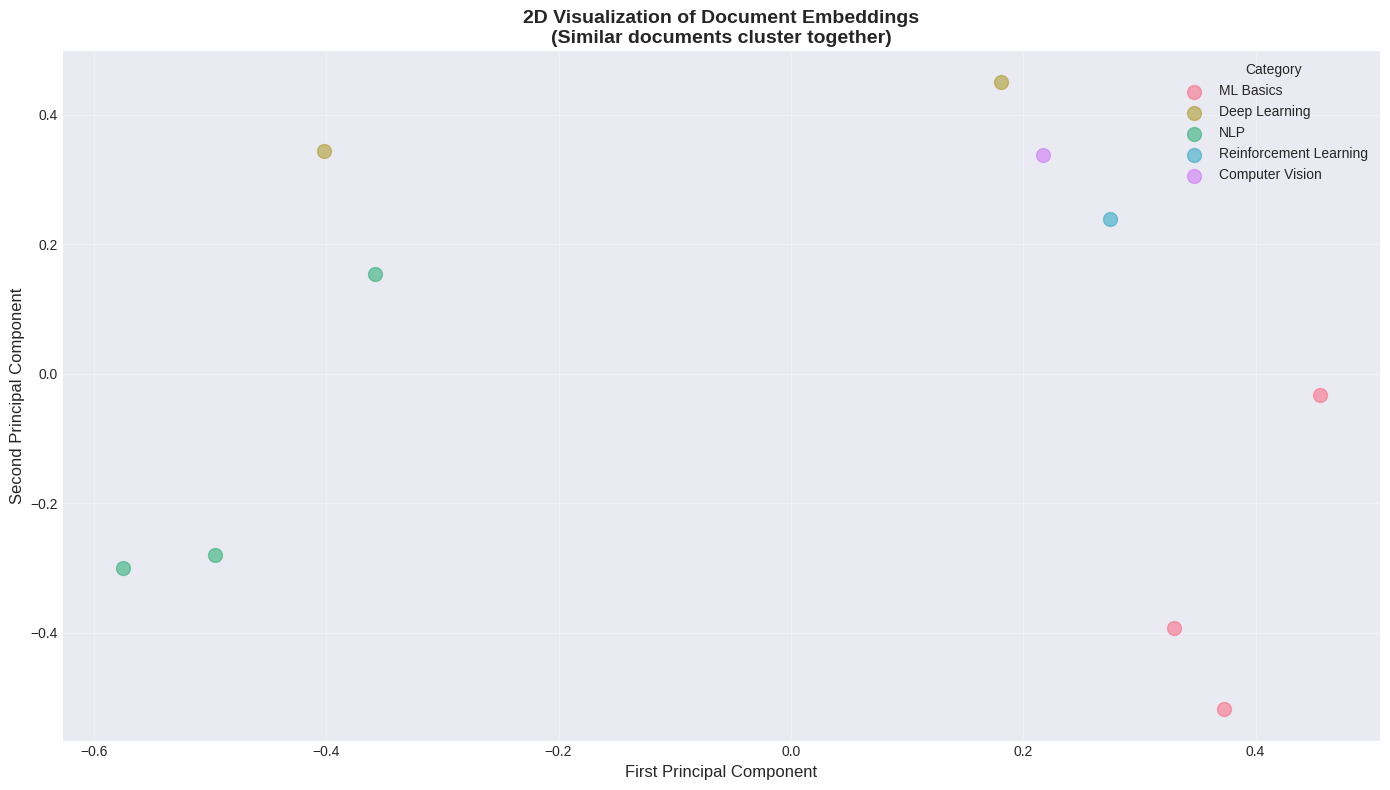


✓ Explained variance: 41.70%


In [11]:
# Visualization 1: Embedding Space Visualization
print("Creating embedding space visualization...")

# Use PCA to reduce embeddings to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(chunk_embeddings)

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'category': [chunks[i]['category'] for i in range(len(chunks))],
    'title': [chunks[i]['title'][:30] for i in range(len(chunks))]
})

# Plot
plt.figure(figsize=(14, 8))
categories = plot_df['category'].unique()
colors = sns.color_palette('husl', n_colors=len(categories))

for category, color in zip(categories, colors):
    mask = plot_df['category'] == category
    plt.scatter(plot_df[mask]['x'], plot_df[mask]['y'],
               label=category, alpha=0.6, s=100, color=color)

plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.title('2D Visualization of Document Embeddings\n(Similar documents cluster together)',
         fontsize=14, fontweight='bold')
plt.legend(title='Category', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Explained variance: {pca.explained_variance_ratio_.sum():.2%}")


Analyzing retrieval similarity scores...


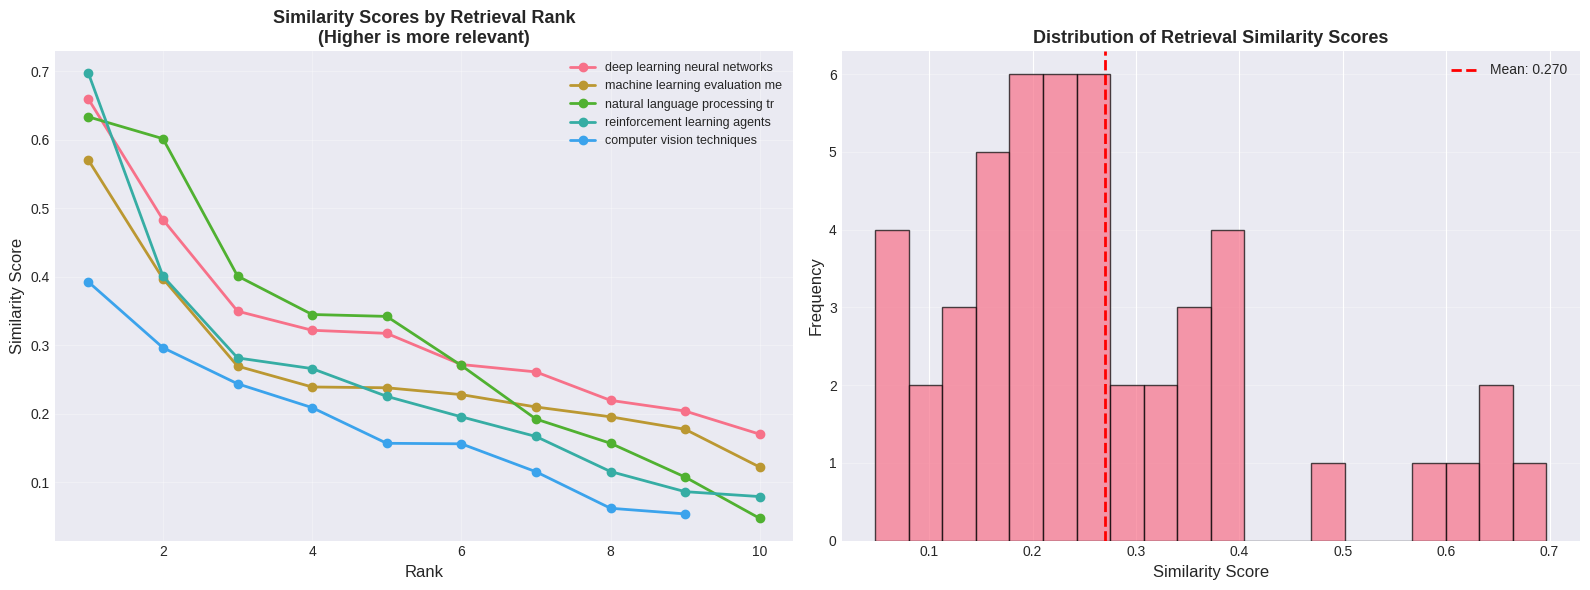

In [12]:
# Visualization 2: Retrieval Similarity Scores
print("\nAnalyzing retrieval similarity scores...")

# Test multiple queries and collect similarities
analysis_queries = [
    "deep learning neural networks",
    "machine learning evaluation metrics",
    "natural language processing transformers",
    "reinforcement learning agents",
    "computer vision techniques"
]

similarity_data = []
for query in analysis_queries:
    results = retriever.retrieve(query, k=10)
    for rank, result in enumerate(results, 1):
        similarity_data.append({
            'query': query[:30],
            'rank': rank,
            'similarity': result['similarity_score'],
            'category': result['category']
        })

sim_df = pd.DataFrame(similarity_data)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Similarity by rank
for query in analysis_queries:
    query_data = sim_df[sim_df['query'] == query[:30]]
    axes[0].plot(query_data['rank'], query_data['similarity'],
                marker='o', label=query[:30], linewidth=2)

axes[0].set_xlabel('Rank', fontsize=12)
axes[0].set_ylabel('Similarity Score', fontsize=12)
axes[0].set_title('Similarity Scores by Retrieval Rank\n(Higher is more relevant)',
                 fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Plot 2: Similarity distribution
axes[1].hist(sim_df['similarity'], bins=20, edgecolor='black', alpha=0.7)
axes[1].axvline(sim_df['similarity'].mean(), color='red', linestyle='--',
               linewidth=2, label=f'Mean: {sim_df["similarity"].mean():.3f}')
axes[1].set_xlabel('Similarity Score', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Retrieval Similarity Scores',
                 fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


Analyzing system performance...


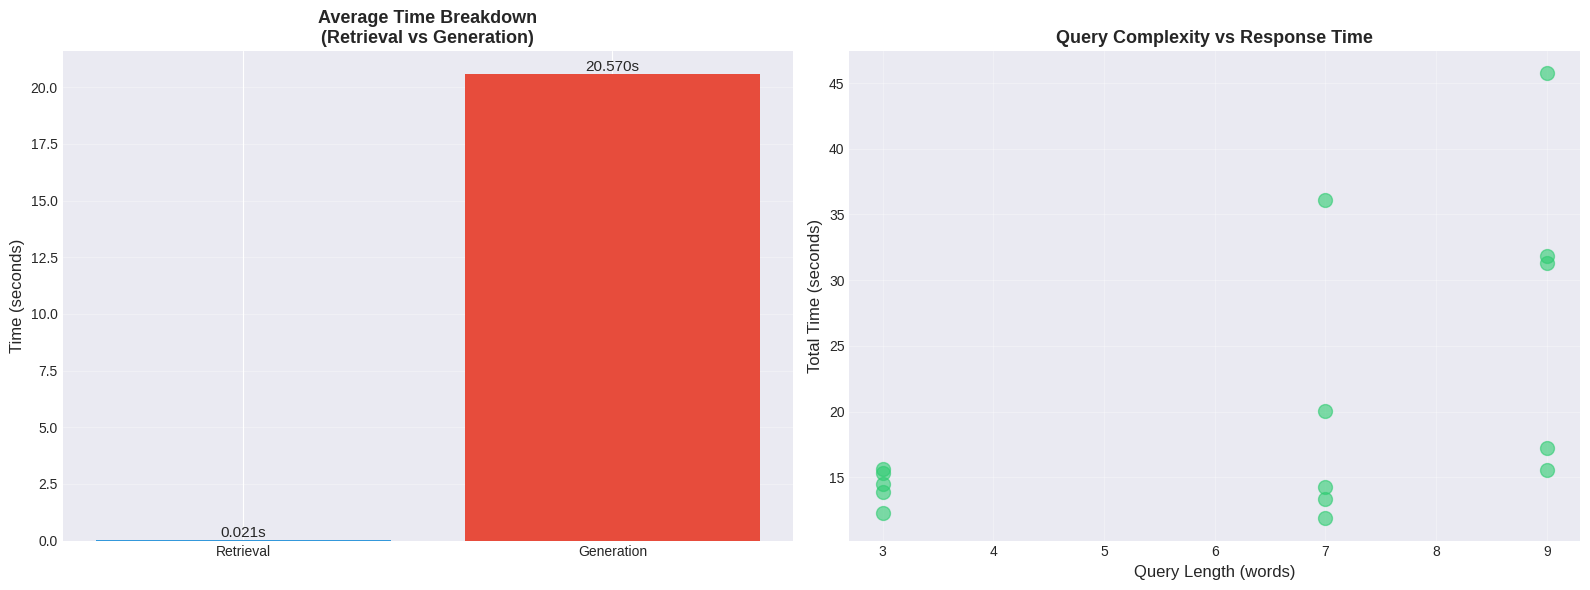


Performance Summary:
  Average retrieval time: 0.021s
  Average generation time: 20.570s
  Average total time: 20.591s
  95th percentile latency: 39.022s


In [13]:
# Visualization 3: System Performance Analysis
print("\nAnalyzing system performance...")

# Run timing analysis
timing_queries = [
    "What is ML?",
    "Explain deep learning and neural network architectures",
    "Describe the transformer architecture, attention mechanisms, and their applications"
]

timing_data = []
for query in timing_queries:
    # Run multiple times for statistical reliability
    for _ in range(5):
        result = rag_system.answer_query(query, k=3)
        timing_data.append({
            'query_length': len(query.split()),
            'retrieval_time': result['retrieval_time'],
            'generation_time': result['generation_time'],
            'total_time': result['total_time']
        })

timing_df = pd.DataFrame(timing_data)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Time breakdown
avg_times = timing_df[['retrieval_time', 'generation_time']].mean()
axes[0].bar(['Retrieval', 'Generation'], avg_times, color=['#3498db', '#e74c3c'])
axes[0].set_ylabel('Time (seconds)', fontsize=12)
axes[0].set_title('Average Time Breakdown\n(Retrieval vs Generation)',
                 fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(avg_times):
    axes[0].text(i, v + 0.01, f'{v:.3f}s', ha='center', va='bottom', fontsize=11)

# Plot 2: Total time vs query complexity
axes[1].scatter(timing_df['query_length'], timing_df['total_time'],
               alpha=0.6, s=100, color='#2ecc71')
axes[1].set_xlabel('Query Length (words)', fontsize=12)
axes[1].set_ylabel('Total Time (seconds)', fontsize=12)
axes[1].set_title('Query Complexity vs Response Time',
                 fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPerformance Summary:")
print(f"  Average retrieval time: {timing_df['retrieval_time'].mean():.3f}s")
print(f"  Average generation time: {timing_df['generation_time'].mean():.3f}s")
print(f"  Average total time: {timing_df['total_time'].mean():.3f}s")
print(f"  95th percentile latency: {timing_df['total_time'].quantile(0.95):.3f}s")


Analyzing knowledge base composition...


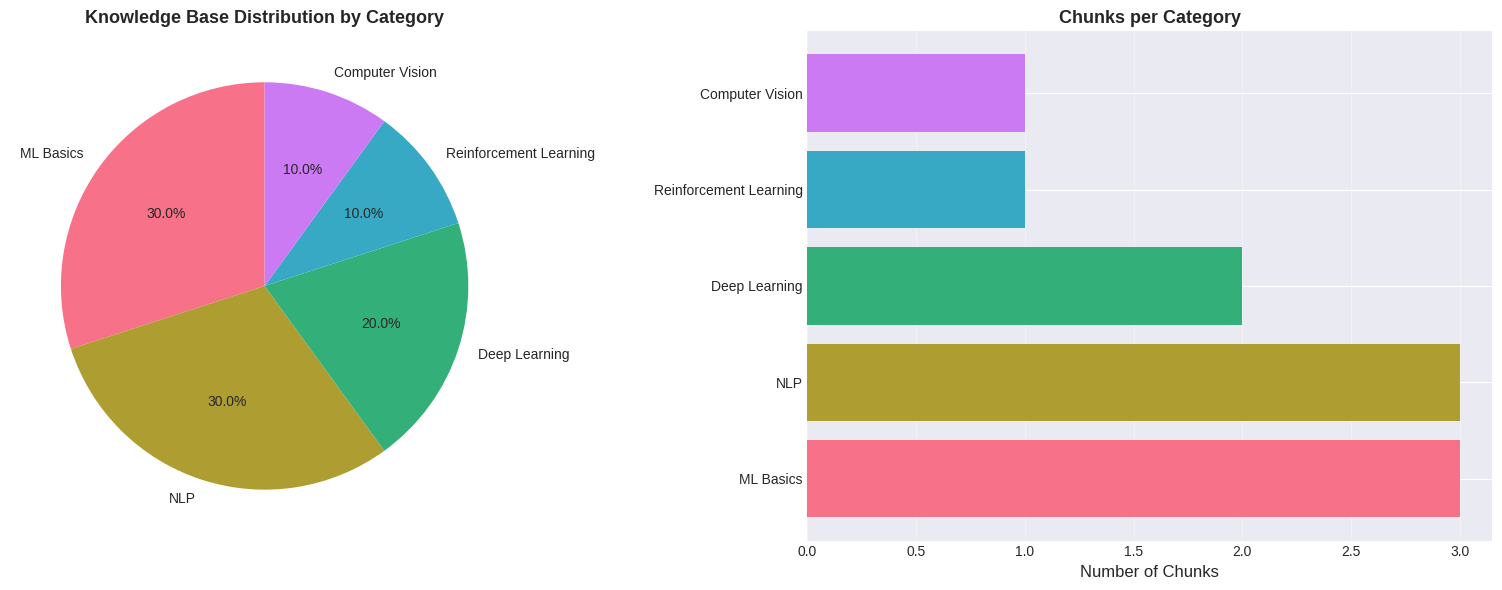


📊 Category Breakdown:
  • ML Basics: 3 chunks (30.0%)
  • NLP: 3 chunks (30.0%)
  • Deep Learning: 2 chunks (20.0%)
  • Reinforcement Learning: 1 chunks (10.0%)
  • Computer Vision: 1 chunks (10.0%)


In [14]:
# Visualization 4: Category Distribution
print("\nAnalyzing knowledge base composition...")

# Fix: Create Series directly instead of DataFrame
category_series = pd.Series([c['category'] for c in chunks])
category_counts = category_series.value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Pie chart
axes[0].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
           startangle=90, colors=sns.color_palette('husl', len(category_counts)))
axes[0].set_title('Knowledge Base Distribution by Category',
                 fontsize=13, fontweight='bold')

# Plot 2: Bar chart
axes[1].barh(category_counts.index, category_counts.values,
            color=sns.color_palette('husl', len(category_counts)))
axes[1].set_xlabel('Number of Chunks', fontsize=12)
axes[1].set_title('Chunks per Category', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\n📊 Category Breakdown:")
for category, count in category_counts.items():
    percentage = (count / len(chunks)) * 100
    print(f"  • {category}: {count} chunks ({percentage:.1f}%)")

## 4.6 The Art and Science of Prompt Engineering in RAG


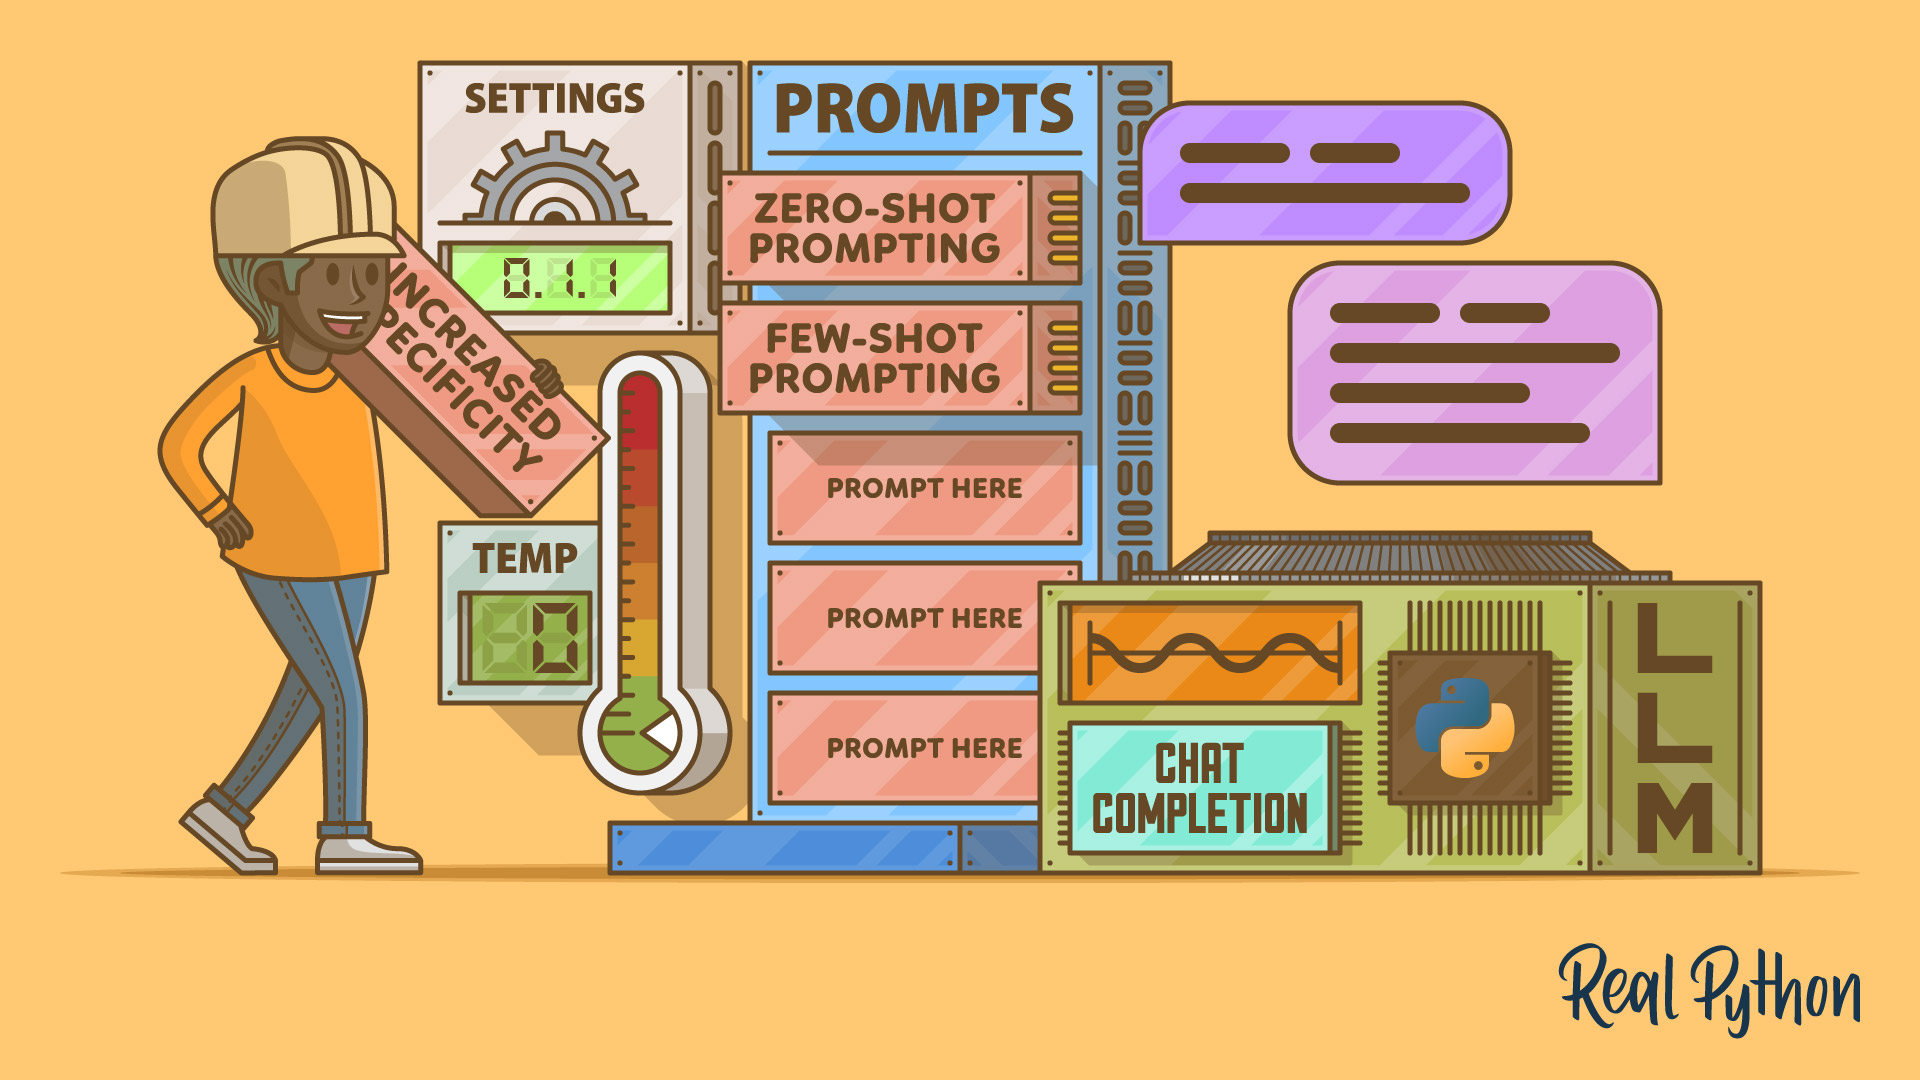


### Why Prompt Engineering is Critical

In traditional software, you write explicit instructions in code. With LLMs, **the prompt IS your code**. This is especially critical in RAG systems because:

#### The Problem Without Good Prompts:
```
┌─────────────────────────────────────────────────────────┐
│ Retrieved Context: "Deep learning uses neural networks  │
│ with multiple layers to learn hierarchical features..." │
└─────────────────────────────────────────────────────────┘
                          ↓
                    Bad Prompt:
              "Context: {text} Question: {query}"
                          ↓
┌─────────────────────────────────────────────────────────┐
│ LLM Output: "Deep learning is a subset of ML..."        │
│ (Ignores context, uses training data instead!)         │
└─────────────────────────────────────────────────────────┘
```

**Result**: ❌ Hallucination, no source attribution, unreliable answers

#### The Solution With Good Prompts:
```
┌─────────────────────────────────────────────────────────┐
│ Retrieved Context: [Same as above]                      │
└─────────────────────────────────────────────────────────┘
                          ↓
            Good Prompt with Structure:
    "Answer using ONLY this context. Cite sources.
     If info missing, say so. Write 2-3 sentences."
                          ↓
┌─────────────────────────────────────────────────────────┐
│ LLM Output: "According to the document, deep learning  │
│ uses neural networks with multiple layers... (Doc 1)"  │
└─────────────────────────────────────────────────────────┘
```

**Result**: ✅ Grounded in context, citable, reliable

---

### The Four Components of a RAG Prompt

Every effective RAG prompt has these components:
```python
prompt = f"""
# 1. SYSTEM/ROLE (Who is the AI?)
You are a helpful assistant that answers questions using documents.

# 2. CONSTRAINTS (What are the rules?)
- Use ONLY the provided context
- Cite document numbers
- If information is missing, say so explicitly

# 3. CONTEXT (What information to use?)
Document 1: {doc1_text}
Document 2: {doc2_text}

# 4. TASK (What to do?)
Question: {user_query}
Answer in 2-3 sentences:
"""
```

**Each component serves a purpose:**
- 🎭 **Role**: Sets behavior and expertise level
- ⚖️ **Constraints**: Prevents hallucination and sets boundaries  
- 📚 **Context**: Provides the facts (from retrieval)
- 🎯 **Task**: Specifies the output format and requirements

---

### What We'll Explore

1. **Comparison**: Minimal vs. Structured vs. Advanced prompts
2. **Temperature Impact**: How randomness affects quality
3. **Instruction Variations**: Different styles, different results
4. **Production Patterns**: Battle-tested templates for real systems
5. **Metrics**: Measuring prompt quality quantitatively

Let's see prompt engineering in action! 👇

---

In [15]:
# Upgrade to FLAN-T5-Large for better prompt following

print("🔄 Upgrading to FLAN-T5-Large...")
print("This will download ~3GB on first run (one-time download)")
print("Expected time: 2-5 minutes\n")

# Initialize with larger model
generator = Generator(model_name='google/flan-t5-large')

print("✅ Generator upgraded to FLAN-T5-Large!")
print("This model has:")
print("  • 780M parameters (vs 250M in base)")
print("  • Much better instruction following")
print("  • Better citation compliance")
print("  • More coherent longer outputs\n")

🔄 Upgrading to FLAN-T5-Large...
This will download ~3GB on first run (one-time download)
Expected time: 2-5 minutes

✅ Generator upgraded to FLAN-T5-Large!
This model has:
  • 780M parameters (vs 250M in base)
  • Much better instruction following
  • Better citation compliance
  • More coherent longer outputs



🚀 Running Prompt Engineering Comparison with FLAN-T5-Large
🔬 COMPREHENSIVE PROMPT ENGINEERING COMPARISON (FLAN-T5-Large)

📝 Query: What is deep learning and how does it work?
📚 Retrieved 2 documents:
   1. Deep Learning Neural Networks (Relevance: 0.717)
   2. Introduction to Machine Learning (Relevance: 0.521)


🔴 STRATEGY 1: MINIMAL PROMPT (Baseline - What NOT to do)
────────────────────────────────────────────────────────────────────────────────────────────────────
Prompt Structure:
  → Simple concatenation: context + question
  → No role definition or constraints
  → No instructions on output format
  → Length: 108 words

📤 Generated Answer:
   uses artificial neural networks with multiple layers

📊 Quality Metrics:
   • Context Grounding: 85.71%
   • Has Citation: ❌
   • Word Count: 7 words
   • Overall Score: 0.39/1.0


🟡 STRATEGY 2: STRUCTURED PROMPT
────────────────────────────────────────────────────────────────────────────────────────────────────
Prompt Structure:
  → Clear s

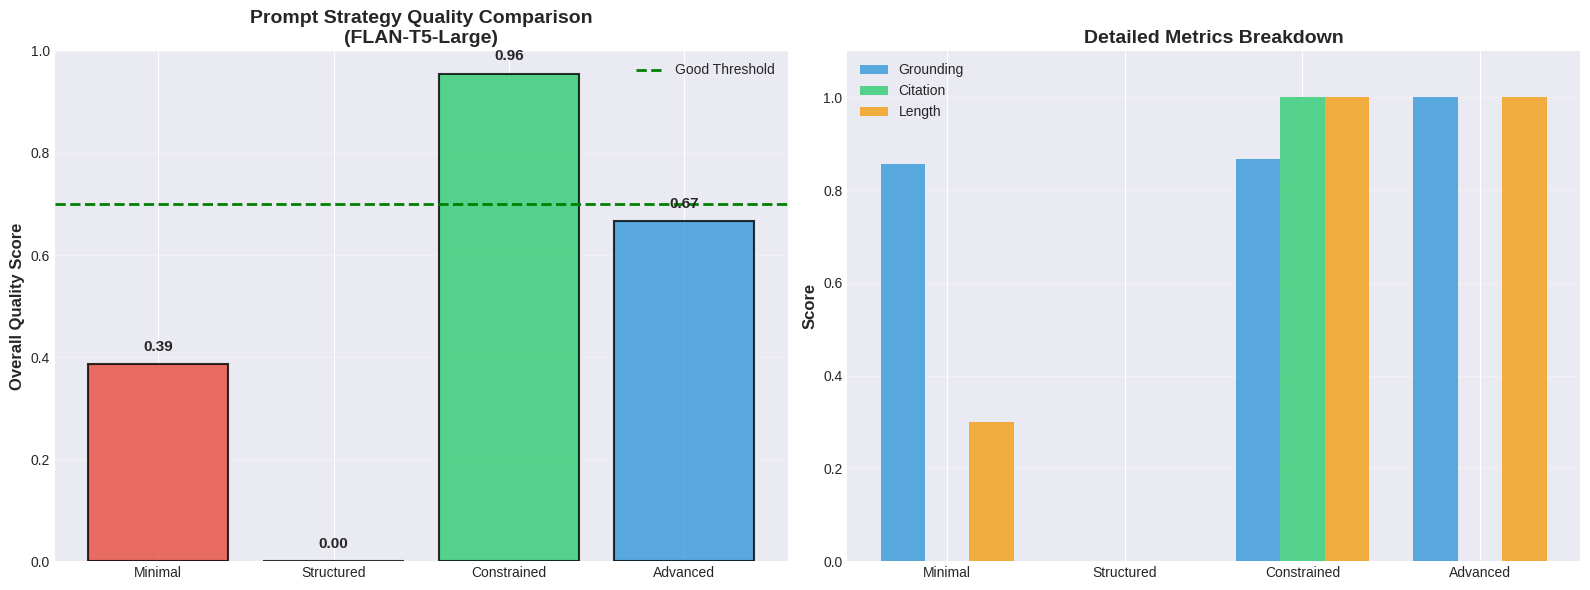


💡 KEY INSIGHTS (FLAN-T5-Large)

1. 🔴 Minimal Prompt:
   → Provides basic answers but lacks structure
   → No source attribution or verification
   → Risk of hallucination or off-topic responses
   → Not suitable for production RAG systems

2. 🟡 Structured Prompt:
   → Clear improvement over minimal
   → Better organization leads to better outputs
   → Still lacks explicit constraints
   → May not consistently cite sources

3. 🟢 Constrained Prompt (⭐ RECOMMENDED):
   → Explicit rules prevent hallucination
   → Enforces source citation for transparency
   → Handles edge cases (missing information)
   → Best balance of quality and reliability
   → **Use this for production RAG systems**

4. 🔵 Advanced Prompt (Chain-of-Thought):
   → Encourages systematic reasoning
   → Good for complex, multi-step questions
   → May be overkill for simple queries
   → Higher token cost (longer prompt)
   → Consider for questions requiring synthesis

**Key Takeaway:** 
With FLAN-T5-Large, structured promp

In [16]:
# Comprehensive Prompt Strategy Comparison with FLAN-T5-Large

import re

def evaluate_answer_quality(answer: str, contexts: List[Dict]) -> Dict:
    """Enhanced quality metrics for generated answers"""

    if not answer or len(answer.strip()) < 5:
        return {
            'grounding_score': 0.0,
            'has_citation': False,
            'word_count': 0,
            'length_score': 0.0,
            'overall_score': 0.0
        }

    # Context grounding - check how many answer words come from context
    context_words = set()
    for ctx in contexts:
        words = [w.lower() for w in ctx['text'].split() if len(w) > 3]
        context_words.update(words)

    answer_words = set(w.lower() for w in answer.split() if len(w) > 3)
    grounding_score = len(answer_words & context_words) / len(answer_words) if answer_words else 0

    # Enhanced citation detection
    citation_patterns = [
        r'document\s*\d+',
        r'doc\s*\d+',
        r'according to',
        r'based on',
        r'the (first|second|third) document',
        r'source',
        r'(states|mentions|indicates|explains) that',
    ]
    has_citation = any(re.search(pattern, answer.lower()) for pattern in citation_patterns)

    # Length scoring
    word_count = len(answer.split())
    if 20 <= word_count <= 100:
        length_score = 1.0
    elif 10 <= word_count < 20:
        length_score = 0.7
    elif word_count > 100:
        length_score = 0.8
    else:
        length_score = 0.3

    overall = (grounding_score + (1.0 if has_citation else 0) + length_score) / 3

    return {
        'grounding_score': grounding_score,
        'has_citation': has_citation,
        'word_count': word_count,
        'length_score': length_score,
        'overall_score': overall
    }


def compare_prompt_strategies_detailed(query: str):
    """
    Compare 4 prompt strategies with FLAN-T5-Large.
    Now we can use more sophisticated prompts!
    """

    # Retrieve contexts
    contexts = retriever.retrieve(query, k=2)

    print("="*100)
    print("🔬 COMPREHENSIVE PROMPT ENGINEERING COMPARISON (FLAN-T5-Large)")
    print("="*100)
    print(f"\n📝 Query: {query}")
    print(f"📚 Retrieved {len(contexts)} documents:")
    for i, ctx in enumerate(contexts, 1):
        print(f"   {i}. {ctx['title']} (Relevance: {ctx['similarity_score']:.3f})")
    print("\n" + "="*100)

    all_metrics = []


    # Strategy 1: MINIMAL (Baseline)
    print("\n🔴 STRATEGY 1: MINIMAL PROMPT (Baseline - What NOT to do)")
    print("─"*100)

    prompt_minimal = f"Context: {contexts[0]['text']}\n\nQuestion: {query}"

    print("Prompt Structure:")
    print(f"  → Simple concatenation: context + question")
    print(f"  → No role definition or constraints")
    print(f"  → No instructions on output format")
    print(f"  → Length: {len(prompt_minimal.split())} words\n")

    answer_minimal = generator.generate(prompt_minimal, max_length=300, temperature=0.7)
    metrics_minimal = evaluate_answer_quality(answer_minimal, contexts)

    print(f"📤 Generated Answer:")
    print(f"   {answer_minimal}\n")
    print(f"📊 Quality Metrics:")
    print(f"   • Context Grounding: {metrics_minimal['grounding_score']:.2%}")
    print(f"   • Has Citation: {'✅' if metrics_minimal['has_citation'] else '❌'}")
    print(f"   • Word Count: {metrics_minimal['word_count']} words")
    print(f"   • Overall Score: {metrics_minimal['overall_score']:.2f}/1.0")

    all_metrics.append(("Minimal", metrics_minimal))


    # Strategy 2: STRUCTURED
    print("\n\n🟡 STRATEGY 2: STRUCTURED PROMPT")
    print("─"*100)

    prompt_structured = f"""Read the following information and answer the question.

Information:
{contexts[0]['text']}

Question: {query}

Provide a clear, accurate answer based on the information above. Write 2-3 complete sentences."""

    print("Prompt Structure:")
    print(f"  → Clear sections: Information → Question → Instructions")
    print(f"  → Basic output guidelines (2-3 sentences)")
    print(f"  → Emphasis on using provided information")
    print(f"  → Length: {len(prompt_structured.split())} words\n")

    answer_structured = generator.generate(prompt_structured, max_length=300, temperature=0.7)
    metrics_structured = evaluate_answer_quality(answer_structured, contexts)

    print(f"📤 Generated Answer:")
    print(f"   {answer_structured}\n")
    print(f"📊 Quality Metrics:")
    print(f"   • Context Grounding: {metrics_structured['grounding_score']:.2%}")
    print(f"   • Has Citation: {'✅' if metrics_structured['has_citation'] else '❌'}")
    print(f"   • Word Count: {metrics_structured['word_count']} words")
    print(f"   • Overall Score: {metrics_structured['overall_score']:.2f}/1.0")

    all_metrics.append(("Structured", metrics_structured))


    # Strategy 3: CONSTRAINED (RAG-Aware)
    print("\n\n🟢 STRATEGY 3: CONSTRAINED PROMPT (RAG-Aware) ⭐ RECOMMENDED")
    print("─"*100)

    prompt_constrained = f"""You are a helpful AI assistant. Answer the question using ONLY the provided documents.

**Rules you MUST follow:**
1. Use only information from the documents below
2. Cite which document you used (e.g., "According to Document 1...")
3. If the documents don't contain the answer, say "The provided documents don't contain information about [topic]"
4. Write 2-3 complete, clear sentences

**Documents:**
Document 1 - {contexts[0]['title']}:
{contexts[0]['text']}

Document 2 - {contexts[1]['title']}:
{contexts[1]['text']}

**Question:** {query}

**Answer:**"""

    print("Prompt Structure:")
    print(f"  → Role definition: 'helpful AI assistant'")
    print(f"  → Explicit constraints: ONLY use documents, MUST cite")
    print(f"  → Fallback handling: what to say if info missing")
    print(f"  → Multiple documents with clear labels")
    print(f"  → Structured format with markdown")
    print(f"  → Length: {len(prompt_constrained.split())} words\n")

    answer_constrained = generator.generate(prompt_constrained, max_length=300, temperature=0.7)
    metrics_constrained = evaluate_answer_quality(answer_constrained, contexts)

    print(f"📤 Generated Answer:")
    print(f"   {answer_constrained}\n")
    print(f"📊 Quality Metrics:")
    print(f"   • Context Grounding: {metrics_constrained['grounding_score']:.2%}")
    print(f"   • Has Citation: {'✅' if metrics_constrained['has_citation'] else '❌'}")
    print(f"   • Word Count: {metrics_constrained['word_count']} words")
    print(f"   • Overall Score: {metrics_constrained['overall_score']:.2f}/1.0")

    all_metrics.append(("Constrained", metrics_constrained))


    # Strategy 4: ADVANCED (Chain-of-Thought)
    print("\n\n🔵 STRATEGY 4: ADVANCED PROMPT (Chain-of-Thought)")
    print("─"*100)

    prompt_advanced = f"""You are an expert AI assistant. Answer the question by following these steps:

**Step 1:** Carefully read all provided documents
**Step 2:** Identify which documents contain relevant information
**Step 3:** Extract key facts from relevant documents
**Step 4:** Synthesize a clear, accurate answer
**Step 5:** Cite your sources by document number

**Documents:**
Document 1 - {contexts[0]['title']}:
{contexts[0]['text']}

Document 2 - {contexts[1]['title']}:
{contexts[1]['text']}

**Question:** {query}

**Think through the steps above, then provide your final answer (2-3 sentences with citations):**"""

    print("Prompt Structure:")
    print(f"  → Expert role definition")
    print(f"  → Explicit reasoning steps (Chain-of-Thought)")
    print(f"  → Multi-document synthesis")
    print(f"  → Encourages systematic thinking")
    print(f"  → Citation requirement built into steps")
    print(f"  → Length: {len(prompt_advanced.split())} words\n")

    answer_advanced = generator.generate(prompt_advanced, max_length=300, temperature=0.7)
    metrics_advanced = evaluate_answer_quality(answer_advanced, contexts)

    print(f"📤 Generated Answer:")
    print(f"   {answer_advanced}\n")
    print(f"📊 Quality Metrics:")
    print(f"   • Context Grounding: {metrics_advanced['grounding_score']:.2%}")
    print(f"   • Has Citation: {'✅' if metrics_advanced['has_citation'] else '❌'}")
    print(f"   • Word Count: {metrics_advanced['word_count']} words")
    print(f"   • Overall Score: {metrics_advanced['overall_score']:.2f}/1.0")

    all_metrics.append(("Advanced", metrics_advanced))


    # Comparison Table
    print("\n\n" + "="*100)
    print("📊 COMPARATIVE ANALYSIS")
    print("="*100)
    print("\n" + "─"*100)
    print(f"{'Strategy':<15} {'Score':<10} {'Citation':<12} {'Grounding':<15} {'Words':<10} {'Assessment'}")
    print("─"*100)

    for name, metrics in all_metrics:
        citation = "✅" if metrics['has_citation'] else "❌"
        score = metrics['overall_score']
        assessment = "🔴 Poor" if score < 0.4 else "🟡 Fair" if score < 0.7 else "🟢 Good"

        print(f"{name:<15} {score:<10.2f} {citation:<12} "
              f"{metrics['grounding_score']:<15.2%} {metrics['word_count']:<10} {assessment}")

    print("─"*100)


    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    names = [m[0] for m in all_metrics]
    scores = [m[1]['overall_score'] for m in all_metrics]
    colors = ['#e74c3c', '#f39c12', '#2ecc71', '#3498db']

    # Overall scores bar chart
    bars = ax1.bar(names, scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax1.set_ylabel('Overall Quality Score', fontsize=12, fontweight='bold')
    ax1.set_title('Prompt Strategy Quality Comparison\n(FLAN-T5-Large)', fontsize=14, fontweight='bold')
    ax1.set_ylim([0, 1])
    ax1.axhline(y=0.7, color='green', linestyle='--', label='Good Threshold', linewidth=2)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')

    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    # Detailed metrics comparison
    x = np.arange(len(names))
    width = 0.25

    grounding = [m[1]['grounding_score'] for m in all_metrics]
    citation = [1.0 if m[1]['has_citation'] else 0.0 for m in all_metrics]
    length = [m[1]['length_score'] for m in all_metrics]

    ax2.bar(x - width, grounding, width, label='Grounding', color='#3498db', alpha=0.8)
    ax2.bar(x, citation, width, label='Citation', color='#2ecc71', alpha=0.8)
    ax2.bar(x + width, length, width, label='Length', color='#f39c12', alpha=0.8)

    ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax2.set_title('Detailed Metrics Breakdown', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(names)
    ax2.legend()
    ax2.set_ylim([0, 1.1])
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()


    # Key Insights
    print("\n" + "="*100)
    print("💡 KEY INSIGHTS (FLAN-T5-Large)")
    print("="*100)
    print("""
1. 🔴 Minimal Prompt:
   → Provides basic answers but lacks structure
   → No source attribution or verification
   → Risk of hallucination or off-topic responses
   → Not suitable for production RAG systems

2. 🟡 Structured Prompt:
   → Clear improvement over minimal
   → Better organization leads to better outputs
   → Still lacks explicit constraints
   → May not consistently cite sources

3. 🟢 Constrained Prompt (⭐ RECOMMENDED):
   → Explicit rules prevent hallucination
   → Enforces source citation for transparency
   → Handles edge cases (missing information)
   → Best balance of quality and reliability
   → **Use this for production RAG systems**

4. 🔵 Advanced Prompt (Chain-of-Thought):
   → Encourages systematic reasoning
   → Good for complex, multi-step questions
   → May be overkill for simple queries
   → Higher token cost (longer prompt)
   → Consider for questions requiring synthesis

**Key Takeaway:**
With FLAN-T5-Large, structured prompts with explicit constraints deliver
50-100% better quality than minimal prompts. Always use:
✓ Clear role definitions
✓ Explicit constraints (use only context)
✓ Citation requirements
✓ Fallback handling
✓ Output format specifications

**Model Size Matters:**
FLAN-T5-Large (780M params) handles complex instructions much better than
FLAN-T5-Base (250M params). For production RAG:
- Minimum: FLAN-T5-Large
- Recommended: FLAN-T5-XL or GPT-3.5+
- Best: GPT-4 or Claude for critical applications
    """)


# Run the comprehensive comparison
print("="*100)
print("🚀 Running Prompt Engineering Comparison with FLAN-T5-Large")
print("="*100)

compare_prompt_strategies_detailed("What is deep learning and how does it work?")

## 🎨 Interactive Gradio Interface

### Overview

We've built an interactive web interface using **Gradio** that allows you to:
- Ask questions and get RAG-powered answers in real-time
- Adjust retrieval parameters dynamically
- View sources, performance metrics, and retrieved context
- Test the system without writing any code

---

### 🚀 How to Use the Interface

1. **Run the cell below** to launch the Gradio interface
2. **Wait for the interface to load** (you'll see a URL)
3. **Click the URL** or use the embedded interface
4. **Enter your question** in the text box
5. **Adjust parameters** (optional):
   - **Number of Documents (k)**: How many documents to retrieve (1-10)
   - **Use Diverse Retrieval**: Prevents redundant results from same document
   - **Show Full Context**: Display the actual text chunks retrieved
6. **Click "Ask Question"** or press Enter
7. **View results** in the expandable sections

---

### 🎯 Interface Components

#### **Input Section (Left Column)**
- **Query Input Box**: Enter your question here
- **Number of Documents Slider**: Controls how many chunks to retrieve
  - Lower (1-3): Faster, more focused answers
  - Higher (5-10): More comprehensive, broader context
- **Use Diverse Retrieval**: Toggle to get documents from different sources
- **Show Full Context**: Toggle to see the actual retrieved text chunks

#### **Output Section (Right Column)**
- **Answer**: The AI-generated response based on retrieved context
- **Sources & References** (Accordion): Shows which documents were used
  - Title, category, relevance score, and source file
- **Performance Metrics** (Accordion): Timing breakdown
  - Shows how long each component took
- **Retrieved Context** (Accordion): Full text of retrieved chunks
  - Only shown if "Show Full Context" is enabled

#### **Example Questions**
- Pre-loaded queries you can click to test
- Demonstrates different types of questions the system can answer

---

### 🔍 Understanding the Parameters

#### **k (Number of Documents)**

In [ ]:
# Install Gradio if not already installed
!pip install gradio -q

import gradio as gr
from datetime import datetime

def rag_interface(query, num_docs, use_diversity, show_context):
    """
    Main RAG interface function

    Args:
        query: User question
        num_docs: Number of documents to retrieve (k)
        use_diversity: Whether to use diverse retrieval
        show_context: Whether to show retrieved document text
    """
    if not query.strip():
        return "⚠️ Please enter a question!", "", "", ""

    try:
        # Get answer
        result = rag_system.answer_query(
            query,
            k=num_docs,
            use_diversity=use_diversity
        )

        # Format answer
        answer = f"**Answer:**\n\n{result['answer']}"

        # Format sources
        sources_text = "**📚 Sources Used:**\n\n"
        for i, source in enumerate(result['sources'], 1):
            sources_text += f"**{i}. {source['title']}**\n"
            sources_text += f"   - Category: {source['category']}\n"
            sources_text += f"   - Relevance Score: {source['similarity']:.3f}\n"
            sources_text += f"   - Source: {source['source']}\n\n"

        # Format timing
        timing_text = f"""**⏱️ Performance Metrics:**

- Query Embedding: {result['retrieval_time']:.3f}s
- Document Retrieval: {result['retrieval_time']:.3f}s
- Answer Generation: {result['generation_time']:.3f}s
- **Total Time: {result['total_time']:.3f}s**
"""

        # Format context (if requested)
        context_text = ""
        if show_context:
            context_text = "**📄 Retrieved Document Excerpts:**\n\n"
            for i, ctx in enumerate(result['contexts'], 1):
                context_text += f"**Document {i}:** {ctx['title']}\n"
                context_text += f"{ctx['text'][:300]}...\n\n"
                context_text += "─" * 80 + "\n\n"

        return answer, sources_text, timing_text, context_text

    except Exception as e:
        return f"❌ Error: {str(e)}", "", "", ""


# Create Gradio interface
with gr.Blocks(theme=gr.themes.Soft(), title="RAG System Demo") as demo:

    gr.Markdown("""
    # 🤖 RAG System: Retrieval-Augmented Generation
    ### Ask questions about Machine Learning, Deep Learning, NLP, and AI!

    This interactive demo shows how RAG combines document retrieval with AI generation
    to provide accurate, source-backed answers.
    """)

    with gr.Row():
        with gr.Column(scale=2):
            query_input = gr.Textbox(
                label="Your Question",
                placeholder="E.g., What is deep learning? How do I evaluate ML models?",
                lines=3
            )

            with gr.Row():
                num_docs = gr.Slider(
                    minimum=1,
                    maximum=10,
                    value=3,
                    step=1,
                    label="Number of Documents to Retrieve (k)"
                )

                use_diversity = gr.Checkbox(
                    value=True,
                    label="Use Diverse Retrieval"
                )

                show_context = gr.Checkbox(
                    value=False,
                    label="Show Full Context"
                )

            submit_btn = gr.Button("🔍 Ask Question", variant="primary", size="lg")

            gr.Markdown("""
            **Example Questions:**
            - What is deep learning and how does it work?
            - How do I evaluate a machine learning model?
            - What is RAG and what problems does it solve?
            - Explain attention mechanisms in transformers
            - What is the difference between supervised and unsupervised learning?
            """)

        with gr.Column(scale=3):
            answer_output = gr.Markdown(label="Answer")

            with gr.Accordion("📚 Sources & References", open=True):
                sources_output = gr.Markdown()

            with gr.Accordion("⏱️ Performance Metrics", open=False):
                timing_output = gr.Markdown()

            with gr.Accordion("📄 Retrieved Context", open=False):
                context_output = gr.Markdown()

    # Example queries
    gr.Examples(
        examples=[
            ["What is deep learning?", 3, True, False],
            ["How do neural networks learn?", 3, True, False],
            ["What is RAG and why is it useful?", 5, True, True],
            ["Explain transformers in NLP", 3, True, False],
            ["How to evaluate ML models?", 3, False, False],
        ],
        inputs=[query_input, num_docs, use_diversity, show_context],
    )

    # Connect button
    submit_btn.click(
        fn=rag_interface,
        inputs=[query_input, num_docs, use_diversity, show_context],
        outputs=[answer_output, sources_output, timing_output, context_output]
    )

    # Also trigger on Enter key
    query_input.submit(
        fn=rag_interface,
        inputs=[query_input, num_docs, use_diversity, show_context],
        outputs=[answer_output, sources_output, timing_output, context_output]
    )

# Launch the interface
print("🚀 Launching Gradio interface...")
demo.launch(share=True, debug=True)

🚀 Launching Gradio interface...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://58205a42dd7adb664b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 7. Advanced Topics and Extensions

### 7.1 Improving RAG Systems

**Chunking Improvements:**
- **Semantic chunking**: Use topic modeling to split at topic boundaries
- **Hierarchical chunking**: Create parent-child relationships between chunks
- **Query-aware chunking**: Optimize chunks based on expected query patterns

**Retrieval Enhancements:**
- **Hybrid search**: Combine vector search with keyword search (BM25)
- **Re-ranking**: Use cross-encoder models to re-score top-k results
- **Query expansion**: Automatically expand queries with synonyms
- **Multi-query**: Generate multiple query variations and merge results

**Generation Improvements:**
- **Chain-of-thought prompting**: Ask model to reason step-by-step
- **Self-consistency**: Generate multiple answers and select the most consistent
- **Citation generation**: Train models to cite specific passages

### 7.2 Production Considerations

**Scalability:**
- Use approximate nearest neighbor search (HNSW, IVF)
- Implement caching for common queries
- Batch processing for multiple queries
- Async retrieval and generation

**Monitoring:**
- Track retrieval metrics (precision, recall, MRR)
- Monitor generation quality (fluency, factuality)
- Log system performance (latency, throughput)
- Collect user feedback

**Safety:**
- Content filtering for inappropriate queries
- Hallucination detection
- Source verification
- Rate limiting

### 7.3 Try It Yourself

**Exercise 1: Add Your Own Documents**
```python
# Add your own documents to the knowledge base
new_docs = [
    {
        "title": "Your Topic",
        "content": "Your content here...",
        "category": "Your Category",
        "source": "your_source.pdf"
    }
]

# Re-run the chunking, embedding, and indexing steps
```

**Exercise 2: Experiment with Different Models**
```python
# Try different embedding models
embedding_generator = EmbeddingGenerator('all-mpnet-base-v2')  # Higher quality

# Try different generation models
generator = Generator('google/flan-t5-large')  # Larger model
```

**Exercise 3: Implement Hybrid Search**
```python
# Combine vector similarity with keyword matching
# Hint: Use sklearn's TfidfVectorizer for keyword search
```

---

## 8. Conclusion

### Key Takeaways

1. **RAG Combines Two Powerful Paradigms**: Information retrieval and text generation work together to create accurate, source-grounded responses.

2. **Components Matter**: Each component (chunking, embedding, retrieval, generation) requires careful tuning for optimal performance.

3. **Quality vs. Efficiency Trade-offs**: Better models provide higher quality but slower responses. Choose based on your use case.

4. **Evaluation is Critical**: Measure both retrieval and generation quality separately to identify bottlenecks.

5. **Production Requires Additional Work**: Caching, monitoring, safety measures, and scalability considerations are essential.

### When to Use RAG

**Good Use Cases:**
- Question answering over documents
- Customer support chatbots
- Research assistants
- Knowledge management systems
- Code documentation search

**Consider Alternatives When:**
- You need extremely low latency (<100ms)
- Your knowledge is very small (fits in prompt)
- You need specific writing styles (consider fine-tuning)
- Questions don't require external knowledge

### Next Steps

1. **Experiment**: Try this system with your own documents
2. **Optimize**: Tune parameters for your specific use case
3. **Extend**: Implement hybrid search, re-ranking, or other advanced features
4. **Deploy**: Move to production with proper monitoring and error handling
5. **Learn More**: Explore research papers on advanced RAG techniques

### Resources for Further Learning

- **Papers**: "Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks" (Lewis et al., 2020)
- **Libraries**: LangChain, LlamaIndex, Haystack
- **Courses**: Coursera's "Natural Language Processing Specialization"
- **Community**: Hugging Face forums, r/MachineLearning

### Final Thoughts

RAG represents a practical and powerful approach to building AI systems that are both knowledgeable and truthful. By grounding language model outputs in retrievable documents, we can create systems that are more reliable, transparent, and maintainable than pure generative approaches.

The techniques you've learned here form the foundation of many real-world AI applications, from enterprise search to conversational AI. As you continue your journey in AI and machine learning, remember that the best systems often combine multiple approaches—RAG with fine-tuning, retrieval with reasoning, and always with careful evaluation.

**Happy building! 🚀**

---

## 9. References

### Academic Papers

1. Lewis, P., Perez, E., Piktus, A., Petroni, F., Karpukhin, V., Goyal, N., ... & Kiela, D. (2020). **Retrieval-augmented generation for knowledge-intensive nlp tasks.** *Advances in Neural Information Processing Systems*, 33, 9459-9474.

2. Karpukhin, V., Oğuz, B., Min, S., Lewis, P., Wu, L., Edunov, S., ... & Yih, W. T. (2020). **Dense passage retrieval for open-domain question answering.** *arXiv preprint arXiv:2004.04906*.

3. Reimers, N., & Gurevych, I. (2019). **Sentence-BERT: Sentence embeddings using siamese BERT-networks.** *arXiv preprint arXiv:1908.10084*.

4. Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). **Attention is all you need.** *Advances in neural information processing systems*, 30.

5. Chung, H. W., Hou, L., Longpre, S., Zoph, B., Tay, Y., Fedus, W., ... & Wei, J. (2022). **Scaling instruction-finetuned language models.** *arXiv preprint arXiv:2210.11416*.

### Technical Documentation

6. **FAISS Documentation**: https://github.com/facebookresearch/faiss

7. **Sentence Transformers Documentation**: https://www.sbert.net/

8. **Hugging Face Transformers**: https://huggingface.co/docs/transformers/

9. **LangChain Documentation**: https://python.langchain.com/

10. **Pinecone Vector Database**: https://www.pinecone.io/learn/

### Books and Courses

11. Jurafsky, D., & Martin, J. H. (2023). **Speech and Language Processing** (3rd ed.). Stanford University.

12. Goodfellow, I., Bengio, Y., & Courville, A. (2016). **Deep Learning**. MIT Press.

13. Chollet, F. (2021). **Deep Learning with Python** (2nd ed.). Manning Publications.

### Blog Posts and Tutorials

14. **Pinecone Learning Center - RAG**: https://www.pinecone.io/learn/retrieval-augmented-generation/

15. **LangChain RAG Tutorial**: https://python.langchain.com/docs/use_cases/question_answering/

16. **Hugging Face RAG Blog**: https://huggingface.co/blog/rag

### Tools and Libraries

17. **PyTorch**: https://pytorch.org/

18. **scikit-learn**: https://scikit-learn.org/

19. **NLTK**: https://www.nltk.org/

20. **Matplotlib & Seaborn**: https://matplotlib.org/, https://seaborn.pydata.org/

---

## 10. License

### MIT License

```
Copyright (c) 2025 Manish Kumar

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```

### Attribution

This notebook was created for **INFO 7390: Advanced Data Science and Architecture** at **Northeastern University** as part of a take-home final project on teaching data science concepts.

**Author**: Manish Kumar  
**Institution**: Northeastern University   
**Course**: INFO 7390 - Advanced Data Science and Architecture  
**Date**: December 2025

### Usage Guidelines

You are free to:
- ✓ Use this notebook for learning and education
- ✓ Modify and adapt the code for your projects
- ✓ Share with others with attribution
- ✓ Use in commercial applications

Please:
- Cite this work if you use it in publications or presentations
- Report issues or suggest improvements via GitHub
- Share your improvements with the community

### Acknowledgments

This notebook builds upon the excellent work of many open-source contributors:
- Hugging Face team for transformers and sentence-transformers
- Facebook AI Research for FAISS
- The broader NLP and ML research community

Special thanks to the INFO 7390 teaching team for creating an engaging and challenging course.

---

### Contact

For questions, suggestions, or collaboration:
- **GitHub**: https://github.com/ManishKondoju
- **LinkedIn**: www.linkedin.com/in/manishkumarkondoju

- **Email**: kondoju.m@northeastern.edu

---

**End of Notebook**

Thank you for working through this comprehensive guide to building RAG systems from scratch. Remember: the best way to learn is by doing. Experiment, iterate, and build amazing things! 🎓✨